# Aif360 - Communities & Crime dataset

This notebook contains the (polished) results of testing the [violence prediction in communities](#viol_ds) [1] dataset against the [aif360](#aif360_ref) framework [2]. In this dataset, the results are compared individually. Thus, the metrics are compared against the outcome wihtout any data modificaiton.

Content:

1. [Utility Functions](#utils)
2. [Initial Data Exploration](#init_data_exp)
3. [Ethnicity (Eth) as Protected Attribute](#eth_attr)
    1. [Eth - Preprocessing](#eth_preproc)
    2. [Eth - Inprocessing](#eth_inproc)
    3. [Eth - Postprocessing](#eth_postproc)
    4. [Eth - Summary](#eth_sum)
4. [Single Parent (Par) Hausehold as Protected Attribute](#par_attr)
    1. [Par - Preprocessing](#par_preproc)
    2. [Par - Inprocessing](#par_inproc)
    3. [Par - Postprocessing](#par_postproc)
    4. [Par - Summary](#par_sum)
5. [Comparison - Age & Par](#comp_aeth_par)
6. [References](#refs)

First, we import all the necessary libraries and instantiate some utility functions.

In [1]:
# Depending on the exeuction environment, all jupyter-notebook-related packages may have to be installed as well.
# The full list of requirements can be found in the accompanying "requirements.txt"
# However, for the necessary libraries to just execute the cells, please uncomment the following lines.

# !pip install seaborn
# !pip install matplotlib
# !pip install numpy
# !pip install scikit-learn
# !pip install 'aif360[all]'
# !pip install ucimlrepo

In [51]:
# Python vanilla libs
import os
from typing import Literal, Iterable

# Aif360 content & other necessary libraries for aif360
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.datasets.standard_dataset import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

# Other usefull third party libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import Perceptron

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
from ucimlrepo import fetch_ucirepo

from IPython.display import Markdown, display, HTML

import warnings
warnings.filterwarnings('ignore') # Mostly set as some warnings are produced when a 0 value is found in a division which will be skipped

## Utility functions <a name="utils"></a>

Below some utility functions can be found, which will be used throughout the notebook.

In [3]:
# The utility functions:
def get_uci_repo(main_path: os.PathLike, data_id: int, data_rep: str = 'data', 
                file_name: str | None = None , store_local: bool = True) -> tuple:
    ''' Helper function to get a dataset from the uci repository. Stores the data locally, if desired

    params:
        main_path: Current execution path
        data_id: Id of the data repository to fetch
        file_name: Defines the filename, if the data is to be stored locally
        store_local: Toggles if data is to be stored locally

    returns:
        Tuple containing the features on position 0 and the target(s) on position 1 
    '''
    # Check if the data is already downloaded
    data_path = os.path.join(main_path, data_rep)
    # Generate the repository, if not already existend
    if store_local:
        os.makedirs(data_path, exist_ok=True)

    # Define the filenames and the according filepaths
    file_name = f'id_{data_id}' if file_name is None else file_name
    feat_name = file_name + '__features.csv'
    target_name = file_name + '__targets.csv'

    feat_path = os.path.join(data_path, feat_name)
    target_path = os.path.join(data_path, target_name)

    # Fetch dataset 
    if all([os.path.isfile(feat_path), os.path.isfile(target_path)]) and store_local:
        features = pd.read_csv(feat_path)
        targets = pd.read_csv(target_path)
    else:

        data = fetch_ucirepo(id=data_id)    
        features: pd.DataFrame = data.data.features 
        targets = data.data.targets

        if store_local:
            features.to_csv(feat_path)
            targets.to_csv(target_path)
    
    return features, targets


def calc_disp_impact_ratio(df: pd.DataFrame,
                           target_values: pd.Series, 
                           target_col: str,
                           priv_col: str,
                           target_thresh: int,
                           priv_ident: int | float| str = 1, 
                           sep_op: Literal['<', '<=', '==', '!=', '>=', '>'] = '<',
                           round_to: int = 2,
                           verbose: bool = True) -> int | float:
    ''' Helper method to calculate the disparate impact ratio manually, if needed.
    
    params:
        df: The data to get the result from
        target_col: The name of the target column
        target_values: The Series containing the target values to predict
        priv_col: Target column containing the protected attribute
        target_tresh: The target value to surpass
        priv_ident: Identifier for separating the prviledged group from the unpriviledged group. The inverse class
                    will be used to get the inverse result from the according operator
        sep_op: Defines the operand to distinguish in case of separating between numbers. May have the following options:
                '<', '<=', '==', '!=', '>=', '>' (Only "==" and "!=" will work for strings/objects)
        round_to: Specifies how many digits to display in the final result
        verbose: Prints the result of all calculations

    returns:
        The disparate impact ratio as int/float
    '''
    # Attach the target values to have all in one frame
    df = pd.concat([df, target_values], axis=1)
    # First instantiate all "normal operations"
    ops = {'<': df[df[priv_col] < priv_ident], '<=': df[df[priv_col] <= priv_ident], '==': df[df[priv_col] == priv_ident],
           '>': df[df[priv_col] > priv_ident], '!=': df[df[priv_col] != priv_ident], '>=': df[df[priv_col] >= priv_ident]}
           # Then the inverse to get the result of the unpriviledged group
    inverse = {'<': df[df[priv_col] >= priv_ident], '!=': df[df[priv_col] == priv_ident], '>=': df[df[priv_col] < priv_ident],
               '>': df[df[priv_col] <= priv_ident], '==': df[df[priv_col] != priv_ident], '<=': df[df[priv_col] > priv_ident]}

    

    # Get the priviledged datasets & the number of datasets
    priv_df = ops[sep_op]
    num_of_priv = priv_df.shape[0]
    if verbose: print(f'Number of priviledged entities: {num_of_priv}')
    # Now the same for the unpriviledged group
    unpriv_df = inverse[sep_op]
    num_of_unpriv = unpriv_df.shape[0]
    if verbose: print(f'Number of unpriviledged entities: {num_of_unpriv}')

    priv_passed = priv_df[priv_df[target_col] >= target_thresh].shape[0]
    if verbose: print(f'Number of priviledged entities with favourable outcome: {priv_passed}')
    priv_ratio = priv_passed / num_of_priv
    if verbose: print(f'Impact of priviledged group: {priv_ratio}')
    unpriv_passed = unpriv_df[unpriv_df[target_col] >= target_thresh].shape[0]
    if verbose: print(f'Number of unpriviledged entities with favourable outcome: {unpriv_passed}')
    unpriv_ratio = unpriv_passed / num_of_unpriv
    if verbose: print(f'Impact of unpriviledged group: {unpriv_ratio}')
    # Finally, check the disparate impact
    return round(unpriv_ratio / priv_ratio, round_to)


def calc_bin_label_metrics(dataset: StandardDataset, priv_group: dict, unpriv_group: dict, 
                           display_results: bool = True, round_to: int = 2) -> dict:
    ''' Helper function to calculate binary label metrics present in one datatset.
    The output produced here show the metrics of one datset only.

    params:
        dataset: The dataset to calculate the metrics for
        priv_group: The group of the target column considered priviledged
        unpriv_group: The group residing in the target column considered non-priviledged
        display_results: Flag to display the calculation results in the ouptut medium
        round_to: Number of digits to round up to

    returns:
        A dictionary containing all the results
    '''
    metr = BinaryLabelDatasetMetric(dataset=dataset, unprivileged_groups=unpriv_group, privileged_groups=priv_group)

    if display_results:
        # Difference of facvourable outcome between the priviledged & unpriviledged groups. Closer to one = better
        display(Markdown(f'**Disparate Impact Ratio:** ***{round(metr.disparate_impact(), round_to) * 100} %***'))
        #  Difference in the ratio of favorable outcomes between priviledged groups & unpriviledged groups
        display(Markdown(f'**Statistical Parity Difference:** ***{round(metr.statistical_parity_difference(), round_to)}***'))
        # Similarity of data between the neighboring rows
        display(Markdown(f'**Similarity of Data:** ***{round(metr.consistency()[0], round_to) * 100} %***'))
        # Difference of (smoothed) probability between found feature groups
        display(Markdown(f'**Smoothed Empirical Difference Fairness:** ***{round(metr.smoothed_empirical_differential_fairness(), round_to)}***'))

    return {
        'disp_impact_ratio': round(metr.disparate_impact(), round_to),
        'stat_par_diff': round(metr.statistical_parity_difference(), round_to),
        'consistency': round(metr.consistency()[0], round_to),
        'smo_emp_diff_fair': round(metr.smoothed_empirical_differential_fairness(), round_to)
    }


def classify_data(train_data: pd.DataFrame, 
                train_targets: pd.Series, 
                to_predict: pd.Series,
                techniques: Iterable[Literal['rf', 'per', 'cbg', 'abc']] | 
                            Literal['all'] = 'all', 
                **ml_kwargs) -> dict:
    ''' Function to classify a target using one or multiple selectable machine learning modules.

    params:
        train_data: The training data for the ml-modules
        train_targets: Targets used during training
        to_predict: Values to predict after training is concluded
        technique: Either an iterable of the ml-modules to use, or "all" to use all available modules
        ml_kwargs: Keyword arguments to pass onto the machine learning modules

    returns:
        Dictionary containing the prediction array for each chosen technique
    '''
    ml_mods = {'rf': RandomForestClassifier(**ml_kwargs), 'per': Perceptron(**ml_kwargs), 
               'cbg': GradientBoostingClassifier(**ml_kwargs), 'abc': AdaBoostClassifier(**ml_kwargs)}
    results = {}

    # Select all available methods, if this option is chosen
    if techniques == 'all':
        techniques = [key for key in ml_mods]

    for tech in techniques:
        fitted = ml_mods[tech].fit(train_data, train_targets)
        pred = fitted.predict(to_predict)
        results[tech] = pred
    
    return results


def plot_conf_matrices(predicted: pd.Series, actual: pd.Series,
                    suptitle: str = '', ncols: int = 2, nrows: int = 2,
                    figsize: tuple = (15, 10)) -> None:
    ''' Function to plot one or multiple confusion matrices.

    params:
        predictions: Dictionary where the value is the prediciton. The key will be used as subplot-title
        actual: The actual targets
        suptitile: Overall title for the whole image
        ncols: Number of cols
        nrows: Number of rows
        figsize: Size of each subplot

    returns:
        None
    '''


    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    predictions = [it for _, it in predicted.items()]
    labels = [k for k in predicted]
    # counter = 0
    cur_row, cur_col = 0, 0
    fig.suptitle(suptitle)

    # for pred, ax in zip(predictions, axes.flatten()):
    for ind, pred in enumerate(predictions, start=1):
        # print(ax)
        # print(content['rf'])
        ax = plt.subplot(nrows, ncols, ind)

        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(actual, pred)).plot(ax=ax)
        
        ax.set_title(labels[ind - 1])

        # Determine the current pos & update the rows, if necessary
        if cur_col == ncols:
            cur_row += 1
            cur_col = 0   
    
    plt.tight_layout()  
    plt.show()


def calc_ml_perf_metrics(actual: pd.Series, predictions: dict, print_in_cons: bool = False, 
                        display_in_frame: bool = True, round_to: int = 2):
    '''' Function to display some common performance metrics for machine learning techniques.
    Included are the precision, accuracy, recall and f1-Score

    params:
        actual: The actual targets
        predictions: The predicted targets
        print_in_cons: If the result is to be printed into the terminal
        display_in_frame: Defines whether the output is to be printed in a dataframe-style
        round_to: Number of digits to round up to

    returns: 
        A dictionary containing all the results for all given input
    
    '''
    results = {}

    # For each prediction made, calculate the results
    for key, pred in predictions.items():
        accuracy = round(sklearn.metrics.accuracy_score(actual, pred)  * 100, round_to)
        precision = round(sklearn.metrics.precision_score(actual, pred, average="weighted", zero_division=True)  * 100, round_to)
        recall = round(sklearn.metrics.recall_score(actual, pred, average="weighted", zero_division=True)  * 100, round_to)
        f1 = round(sklearn.metrics.f1_score(actual, pred, average="weighted") * 100, round_to)

        if print_in_cons:
            display(Markdown(f'#### Results for {key}'))
            display(Markdown(f'**Accuracy:** ***{accuracy} %***'))
            display(Markdown(f'**Precision:** ***{precision} %***'))
            display(Markdown(f'**Recall:** ***{recall} %***'))
            display(Markdown(f'**F1-Score:** ***{f1} %***'))

        results[key] = {
            'precision': precision,
            'accuracy': accuracy,
            'f1-Score': f1,
            'recall': recall
        }

    if display_in_frame:
        display(Markdown(f'#### Results in %'))
        display(HTML(pd.DataFrame.from_dict(results).to_html()))
        
    return results


def plot_grouped_barchart(data: pd.DataFrame | dict, index_col: str,
                        y_col: str | Iterable,
                        x_col: str | Iterable | None = None,
                        stack_name: str = 'value', 
                        xtick_label_rotation: int = 45) -> None:
    ''' Function to plot a grouped barchart based on the data provided. Data can either be 
    a dataframe or a dictionary.

    params:
        data: The data to plot
        index_col: Name of the column to set the index to. Required, as the stack function
                    is used and a normal index would result in a multi-level frame
        stack_name: Name of the column the other columns are stacked on (Most likely the column which 
                    will contain the actual numeric values which are to be compared)
        x_col: Column to be portraied on the x-axis
        y_col: Column to be visualized on the y-axis
        stack_name: Column column to group by
        xtick_label_rotation: Rotates the column labels of x by the provided number in grade

    returns:
        None
    '''
    # Create a dataframe, if a dictionary was provided
    if isinstance(data, dict):
        data = pd.DataFrame.from_dict(data).reset_index()
   
    # Set the index to avoid generating a multi-level dataframe
    data = data.reset_index()

    if 'index' in data.columns:
        print(f'Renaming the index column to "{index_col}"')
        data = data.rename(columns={'index': index_col})

    # Set the new index
    data = data.set_index(index_col)
    # Stack on the stack_name provided
    data = data.stack().to_frame(y_col).reset_index()

    if 'level_1' in data.columns:
        data = data.rename(columns={'level_1': stack_name})

    # Set x to the index column, if no name was provided
    if x_col is None:
        x_col = index_col

    plot = sns.catplot(data=data, x=x_col, y=y_col, hue=stack_name, kind='bar', palette='bright')
    plot.set_xticklabels(rotation=xtick_label_rotation)

    plt.show()



def plot_cat_3d_barplot(df: pd.DataFrame, x_axis_col: str, y_axis_col: str, z_axis_cols: Iterable, 
                        x_label: str, y_label: str, z_labels: Iterable,
                        figsizes: tuple = (15, 15)) -> None:
    ''' Function to plot a 3D bar chart based on categories displayed on the x and y axes.
    Therefore, x and y must contain categorical data. In addition, the function is designed to compare
    different characteristics of the same categories, so x and y remain static for all plots.

    params:
        df: The dataframe to plot
        x_axis_col: The (static) x-axis column for the plots
        y_axis_col: The (static) y-axis column for the plots
        z_axis_cols:    Any iterable containing all the columns to plot on the z-axis.
                        The main loop in this function uses the length of this parameter
                        to define the number of plots to plot.
        x_label: The label of the x-axis
        y_label: The label of the y-axis
        z_labels: The labels of the z-axis for each plot respectively
        fisizes: The size of each figure

    returns:
        None
    '''

    # Note: The libraries are re-imported because the colourmap tends to brake for some reason
    import matplotlib.colors as colors
    import matplotlib.cm as cm
    import numpy as np

    # Set up an simple counter for the position of the current subplot
    fig_pos = 221
    # Set up the plot figure
    fig = plt.figure(figsize=figsizes)
    
    # Define the static axis
    x_axis = df[x_axis_col].astype('category').cat.codes.to_numpy()
    y_axis = df[y_axis_col].astype('category').cat.codes.to_numpy()
    z_axis = np.zeros(len(x_axis))
    # Define the static widths
    x_width = np.ones(len(x_axis))
    y_width = np.ones(len(x_axis))

    for i, z_ax in enumerate(z_axis_cols):
        # Add the current subplot to the plot
        ax = fig.add_subplot(fig_pos, projection='3d')
        z_width = df[z_ax].to_numpy()

        # Define a colour map for better distinction
        offset = z_width + np.abs(z_width.min())
        fracs = offset.astype(float)/offset.max()
        norm = colors.Normalize(fracs.min(), fracs.max())
        cmap = cm.jet(norm(fracs))
        # Plot the subplot
        ax.bar3d(x_axis, y_axis, z_axis, x_width, y_width, z_width, color=cmap)

        # Set the labels & ticks
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label, labelpad=30.0)
        ax.set_zlabel(z_labels[i])
        ax.set_xticks(ticks=[0.5 + i for i in range(len(df[x_axis_col].unique()))], labels=df[x_axis_col].unique())
        ax.set_yticks([0.5 + i for i in range(len(df[y_axis_col].unique()))], labels=(df[y_axis_col].unique()))

        # Update the figure position
        fig_pos += 1

    # plot the plot
    plt.show()

## Initial data exploration <a name="init_data_exp"></a>

In [4]:
# Get the data
# id of the student performance dataset = 320
data = get_uci_repo(main_path=os.getcwd(), data_id=211, file_name='violence_prediction')
feat, targets = data[0], data[1]

In [5]:
# Display the features
display(HTML(feat.head(10).to_html()))

,Unnamed: 0,State,pop,perHoush,pctBlack,pctWhite,pctAsian,pctHisp,pct12-21,pct12-29,pct16-24,pct65up,persUrban,pctUrban,medIncome,pctWwage,pctWfarm,pctWdiv,pctWsocsec,pctPubAsst,pctRetire,medFamIncome,perCapInc,whitePerCap,blackPerCap,NAperCap,asianPerCap,otherPerCap,hispPerCap,persPoverty,pctPoverty,pctLowEdu,pctNotHSgrad,pctCollGrad,pctUnemploy,pctEmploy,pctEmployMfg,pctEmployProfServ,pctOccupManu,pctOccupMgmt,pctMaleDivorc,pctMaleNevMar,pctFemDivorc,pctAllDivorc,persPerFam,pct2Par,pctKids2Par,pctKids-4w2Par,pct12-17w2Par,pctWorkMom-6,pctWorkMom-18,kidsBornNevrMarr,pctKidsBornNevrMarr,numForeignBorn,pctFgnImmig-3,pctFgnImmig-5,pctFgnImmig-8,pctFgnImmig-10,pctImmig-3,pctImmig-5,pctImmig-8,pctImmig-10,pctSpeakOnlyEng,pctNotSpeakEng,pctLargHousFam,pctLargHous,persPerOccupHous,persPerOwnOccup,persPerRenterOccup,pctPersOwnOccup,pctPopDenseHous,pctSmallHousUnits,medNumBedrm,houseVacant,pctHousOccup,pctHousOwnerOccup,pctVacantBoarded,pctVacant6up,medYrHousBuilt,pctHousWOphone,pctHousWOplumb,ownHousLowQ,ownHousMed,ownHousUperQ,ownHousQrange,rentLowQ,rentMed,rentUpperQ,rentQrange,medGrossRent,medRentpctHousInc,medOwnCostpct,medOwnCostPctWO,persEmergShelt,persHomeless,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,numPolice,policePerPop,policeField,policeFieldPerPop,policeCalls,policCallPerPop,policCallPerOffic,policePerPop2,racialMatch,pctPolicWhite,pctPolicBlack,pctPolicHisp,pctPolicAsian,pctPolicMinority,officDrugUnits,numDiffDrugsSeiz,policAveOT,landArea,popDensity,pctUsePubTrans,policCarsAvail,policOperBudget,pctPolicPatrol,gangUnit,pctOfficDrugUnit,policBudgetPerPop
0,0,NJ,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,5.22,4.47,3.22,91.43,90.17,95.78,95.81,44.56,58.88,31,0.36,1277,8.69,13.00,20.99,30.93,0.93,1.39,2.24,3.30,85.68,1.37,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,1845.9,9.63,NaN,NaN,NaN,NaN,0.00,NaN
1,1,PA,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,6.45,5.42,3.11,86.91,85.33,96.82,86.46,51.14,62.43,43,0.24,1920,5.21,8.65,13.33,22.50,0.43,0.72,1.11,1.87,87.79,1.81,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2186.7,3.84,NaN,NaN,NaN,NaN,0.00,NaN
2,2,OR,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,14.76,12.55,2.95,78.54,78.85,92.37,75.72,66.08,74.19,164,0.88,1468,16.42,23.98,32.08,35.63,0.82,1.20,1.61,1.78,93.11,1.14,2.97,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,112000,37300,370,428,520,150,484,24.1,21.7,11.6,16,0,5.00,44.77,36.60,61.26,82.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2780.9,4.37,NaN,NaN,NaN,NaN,0.00,NaN
3,3,NY,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,27.43,26.76,22.71,10.98,28.15,14.47,12.91,2.98,64.02,62.36,65.38,67.43,59.59,70.27,561,3.84,339,13.86,13.86,15.34,15.34,0.28,0.28,0.31,0.31,94.98,0.56,3.93,2.56,2.37,2.51,2.20,58.18,1.21,45.66,3,669,91.19,54.89,2.54,57.85,1939,7.00,0.87,36400,49

In [6]:
# Display the targets
display(HTML(feat.head(10).to_html()))
# Check all possible target classifications
targets['violentPerPop'].unique()

,Unnamed: 0,State,pop,perHoush,pctBlack,pctWhite,pctAsian,pctHisp,pct12-21,pct12-29,pct16-24,pct65up,persUrban,pctUrban,medIncome,pctWwage,pctWfarm,pctWdiv,pctWsocsec,pctPubAsst,pctRetire,medFamIncome,perCapInc,whitePerCap,blackPerCap,NAperCap,asianPerCap,otherPerCap,hispPerCap,persPoverty,pctPoverty,pctLowEdu,pctNotHSgrad,pctCollGrad,pctUnemploy,pctEmploy,pctEmployMfg,pctEmployProfServ,pctOccupManu,pctOccupMgmt,pctMaleDivorc,pctMaleNevMar,pctFemDivorc,pctAllDivorc,persPerFam,pct2Par,pctKids2Par,pctKids-4w2Par,pct12-17w2Par,pctWorkMom-6,pctWorkMom-18,kidsBornNevrMarr,pctKidsBornNevrMarr,numForeignBorn,pctFgnImmig-3,pctFgnImmig-5,pctFgnImmig-8,pctFgnImmig-10,pctImmig-3,pctImmig-5,pctImmig-8,pctImmig-10,pctSpeakOnlyEng,pctNotSpeakEng,pctLargHousFam,pctLargHous,persPerOccupHous,persPerOwnOccup,persPerRenterOccup,pctPersOwnOccup,pctPopDenseHous,pctSmallHousUnits,medNumBedrm,houseVacant,pctHousOccup,pctHousOwnerOccup,pctVacantBoarded,pctVacant6up,medYrHousBuilt,pctHousWOphone,pctHousWOplumb,ownHousLowQ,ownHousMed,ownHousUperQ,ownHousQrange,rentLowQ,rentMed,rentUpperQ,rentQrange,medGrossRent,medRentpctHousInc,medOwnCostpct,medOwnCostPctWO,persEmergShelt,persHomeless,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,numPolice,policePerPop,policeField,policeFieldPerPop,policeCalls,policCallPerPop,policCallPerOffic,policePerPop2,racialMatch,pctPolicWhite,pctPolicBlack,pctPolicHisp,pctPolicAsian,pctPolicMinority,officDrugUnits,numDiffDrugsSeiz,policAveOT,landArea,popDensity,pctUsePubTrans,policCarsAvail,policOperBudget,pctPolicPatrol,gangUnit,pctOfficDrugUnit,policBudgetPerPop
0,0,NJ,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,5.22,4.47,3.22,91.43,90.17,95.78,95.81,44.56,58.88,31,0.36,1277,8.69,13.00,20.99,30.93,0.93,1.39,2.24,3.30,85.68,1.37,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,1845.9,9.63,NaN,NaN,NaN,NaN,0.00,NaN
1,1,PA,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,6.45,5.42,3.11,86.91,85.33,96.82,86.46,51.14,62.43,43,0.24,1920,5.21,8.65,13.33,22.50,0.43,0.72,1.11,1.87,87.79,1.81,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2186.7,3.84,NaN,NaN,NaN,NaN,0.00,NaN
2,2,OR,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,14.76,12.55,2.95,78.54,78.85,92.37,75.72,66.08,74.19,164,0.88,1468,16.42,23.98,32.08,35.63,0.82,1.20,1.61,1.78,93.11,1.14,2.97,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,112000,37300,370,428,520,150,484,24.1,21.7,11.6,16,0,5.00,44.77,36.60,61.26,82.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2780.9,4.37,NaN,NaN,NaN,NaN,0.00,NaN
3,3,NY,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,27.43,26.76,22.71,10.98,28.15,14.47,12.91,2.98,64.02,62.36,65.38,67.43,59.59,70.27,561,3.84,339,13.86,13.86,15.34,15.34,0.28,0.28,0.31,0.31,94.98,0.56,3.93,2.56,2.37,2.51,2.20,58.18,1.21,45.66,3,669,91.19,54.89,2.54,57.85,1939,7.00,0.87,36400,49

array([ 41.02, 127.56, 218.59, ..., 353.83, 691.17, 918.89])

### Data cleaning tasks:

- Fill in the NaNs where possible
- Convert to dummy values
- Set Violence per Population as target 
- Set up bins to classify the targets

In [7]:
max_targ = targets['violentPerPop'].max()

targ = targets['violentPerPop'].apply(lambda x: 1 if x / max_targ <= 0.2 
                                            else 2 if x / max_targ <= 0.4 
                                            else 3 if x / max_targ <= 0.6 
                                            else 4 if x / max_targ <= 0.8
                                            else 5 )

In [9]:
# Drop all unwanted cols
dropped = feat.drop(columns=['Unnamed: 0'])
# Convert the booleans
dropped = dropped.map(lambda x: 1 if isinstance(x, object) and x == 'yes' else 0 if isinstance(x, object) and x == 'no' else x)
# Then convert the remaining cols to dummies
dummies = pd.get_dummies(dropped)
# Finally, fill the Nulls with the (rounded) median
cleaned = dummies.fillna(feat.median(numeric_only=True).round())

In [10]:
# Check if the null conversion has worked
print(cleaned.isnull().values.any())

False


## Ethnicity as protected attribute <a name="eth_feat"></a>

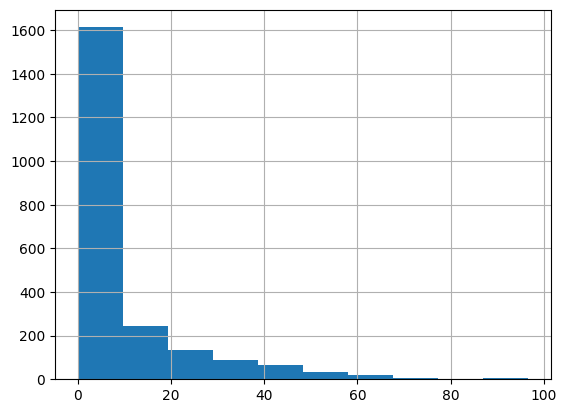

In [12]:
# To see the disparity between the age distribution, we will check said distribution and its ratio as well
cleaned['pctBlack'].hist()
plt.show()

In [18]:
# Eventually, we want to classify all available points. But for now, lets check the disparate impact for students who have passed the year
age_disp_impact = calc_disp_impact_ratio(df=cleaned, target_values=targ, target_col='violentPerPop', priv_col='pctBlack', 
                                        target_thresh=1, priv_ident=0.25, sep_op='>=')

display(Markdown(f'**Disparate Impact Ratio:** ***{age_disp_impact} %***'))

Number of priviledged entities: 2058
Number of unpriviledged entities: 157
Number of priviledged entities with favourable outcome: 2058
Impact of priviledged group: 1.0
Number of unpriviledged entities with favourable outcome: 157
Impact of unpriviledged group: 1.0


**Disparate Impact Ratio:** ***1.0 %***

According to the manual method, there is no difference between the priviledged and unpriviledged group.

In [20]:
# First, we fefine the priviledged & unpriviledged groups, as well as instantiating the dataset.
# This time, we use all individuals ethnicity as protected attributes
eth_priv_group = [{'pctBlack': 1 }, {'pctAsian': 1}, {'pctHisp': 1}]
eth_unpriv_group = [{'pctBlack': 0},  {'pctAsian': 0}, {'pctHisp': 0}, {'pctWhite': 0}]

eth_ds = StandardDataset(df=cleaned,
                    label_name='pctBlack',
                    protected_attribute_names=['pctBlack', 'pctWhite', 'pctAsian', 'pctHisp'],
                    favorable_classes=[1],
                    privileged_classes=[lambda x: 1 if x >= 0.25 else 0]
                    )

Now, we will check the initial comparison metrics provided by aif360

A short summary of the metrics:

|Metric|Description|Reference|
|--|--|--|
|`Disparate Impact Ratio`|Ratio of unprivileged group with favourable outcome to privileged group|[Disparate Impact Ratio](#disp_imp) [3]|
|`Statistical Parity Difference`|In addition to the Disparate Impact, the Statistical Parity Difference calculates the actual difference in the proportion of favourable outcomes between the monitored and reference groups|[Statistical Parity Difference](#stat_par) [4]|
|`Smoothed Empirical Difference Fairness`|Calculates the difference in otucomes between different groups within features|[Smoothed Empirical Difference Fairness](#emp_diff) [5]|

In [21]:
initial_metrics = calc_bin_label_metrics(dataset=eth_ds, priv_group=eth_priv_group, unpriv_group=eth_unpriv_group, display_results=True)

**Disparate Impact Ratio:** ***0.0 %***

**Statistical Parity Difference:** ***-1.0***

**Similarity of Data:** ***92.0 %***

**Smoothed Empirical Difference Fairness:** ***1.1***

What the results tell us:

- According to aif360, there is a maximum difference in higher crime per population (Disparate Impact Ratio = 0%, as well as the maximum difference of -1 in Statistical Parity).
- The data are very similar for all protected groups.
- The smoothed empirical difference does not give a correct result at 110%, but would theoretically indicate that the individual groups of characteristics are very different. 

Finally, we want to check how the ml techinques perform without any data manipulation.

In [22]:
# Determine training- and test-datasets
init_ft_train, init_ft_test, init_targ_train, init_targ_test = train_test_split(cleaned, targ, test_size=0.2)

# Predict the results
init_pred = classify_data(train_data=init_ft_train, train_targets=init_targ_train, to_predict=init_ft_test, techniques='all')

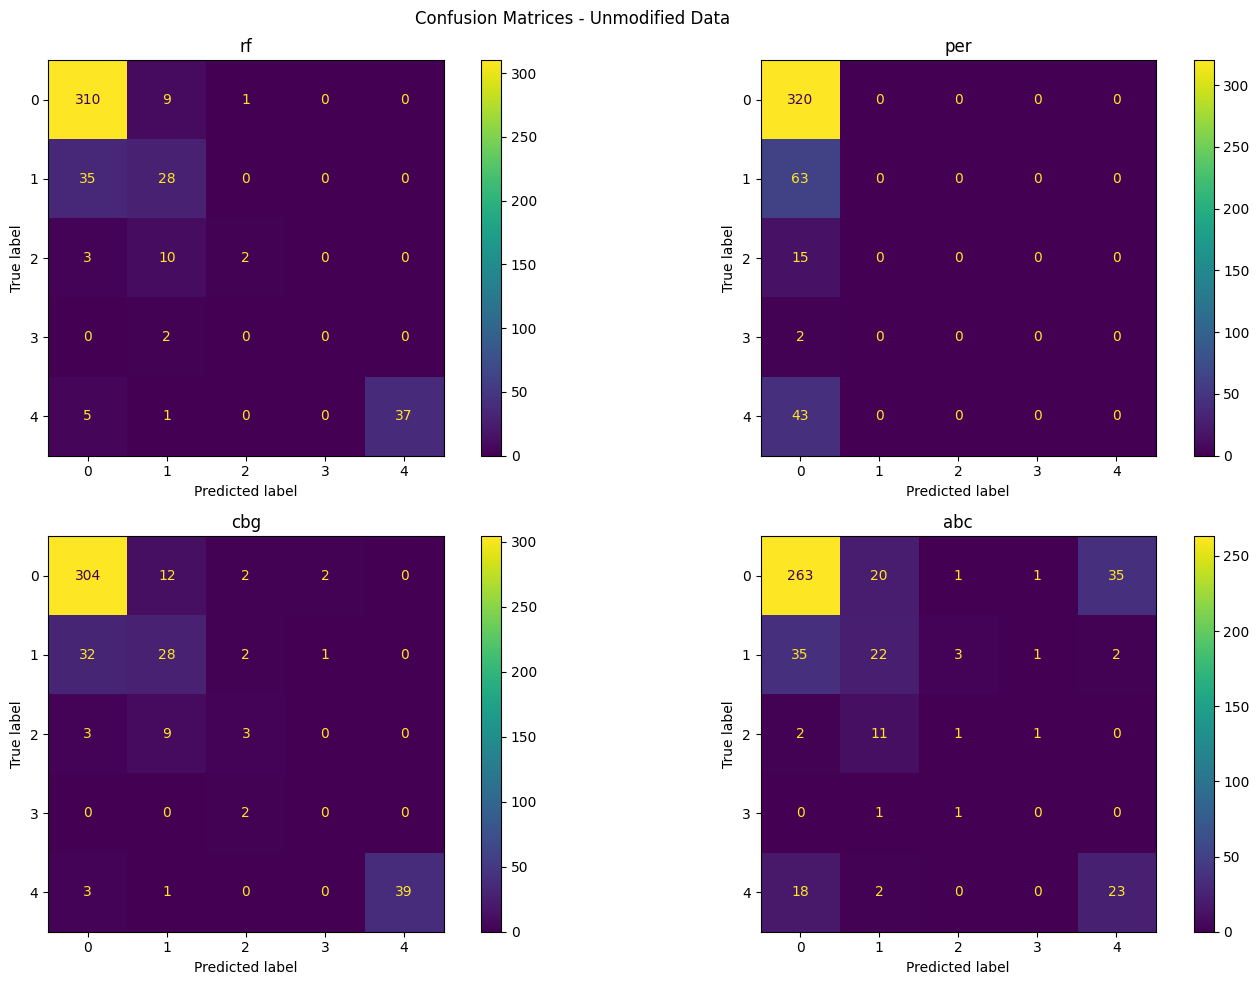

In [23]:
# And check the confusion matrices
plot_conf_matrices(actual=init_targ_test, predicted=init_pred, suptitle='Confusion Matrices - Unmodified Data')

Note:
- [rf](#rf) = RandomForestClassifier [6]
- [per](#per) = Perceptron [7]
- [cbg](#cbg) = GradientBoostingClassifier [8]
- [abc](#abc) = AdaBoostClassifier [9]

From the first exploratory analysis, it seems that all models performed quite well with the "simple" classification bins. Next, we look at the actual performance metrics.

In [24]:
init_perf_metrics = calc_ml_perf_metrics(actual=init_targ_test, predictions=init_pred)

#### Results in %

,rf,per,cbg,abc
precision,83.81,79.94,83.01,69.61
accuracy,85.10,72.23,84.42,69.75
f1-Score,83.32,60.59,83.47,69.47
recall,85.10,72.23,84.42,69.75


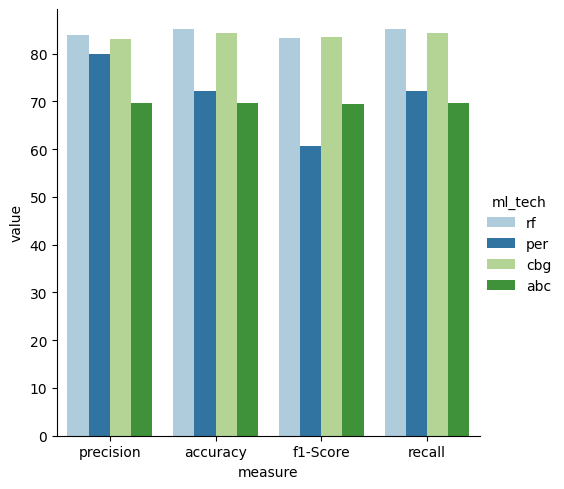

In [25]:
# And a plot for visualizing the comparisons
init_perf_metrics_df = pd.DataFrame.from_dict(init_perf_metrics).reset_index()
init_perf_metrics_df = init_perf_metrics_df.rename(columns={'index': 'measure'})
init_perf_metrics_df = init_perf_metrics_df.set_index('measure')
init_perf_metrics_df = init_perf_metrics_df.stack().to_frame('value').reset_index()
init_perf_metrics_df = init_perf_metrics_df.rename(columns={'level_1': 'ml_tech'})
init_per_plot = sns.catplot(data=init_perf_metrics_df, x='measure', y='value', hue='ml_tech', kind='bar', palette='Paired')

As expected, all models performed surprisingly well. In addition, the `Fairlearn` section has already started to use Random Forests as the main machine learning method. Therefore, Random Forests will be used to compare the frameworks.

##  Ethnicity - Preprocessing <a name="eth_preproc"></a>

The technique for preprocessing we are applying is [Reweighing](#reweighing), which weighs and adapts different examples in each label combination [10]. 

In [26]:
eth_rew_inst = Reweighing(unprivileged_groups=eth_unpriv_group, privileged_groups=eth_priv_group)
eth_rew_fit = eth_rew_inst.fit(eth_ds)
eth_rew_res = eth_rew_fit.transform(eth_ds)

In [27]:
display(HTML(eth_rew_res.convert_to_dataframe()[0].head(10).to_html()))

,pop,perHoush,pctWhite,pctAsian,pctHisp,pct12-21,pct12-29,pct16-24,pct65up,persUrban,pctUrban,medIncome,pctWwage,pctWfarm,pctWdiv,pctWsocsec,pctPubAsst,pctRetire,medFamIncome,perCapInc,whitePerCap,blackPerCap,NAperCap,asianPerCap,otherPerCap,hispPerCap,persPoverty,pctPoverty,pctLowEdu,pctNotHSgrad,pctCollGrad,pctUnemploy,pctEmploy,pctEmployMfg,pctEmployProfServ,pctOccupManu,pctOccupMgmt,pctMaleDivorc,pctMaleNevMar,pctFemDivorc,pctAllDivorc,persPerFam,pct2Par,pctKids2Par,pctKids-4w2Par,pct12-17w2Par,pctWorkMom-6,pctWorkMom-18,kidsBornNevrMarr,pctKidsBornNevrMarr,numForeignBorn,pctFgnImmig-3,pctFgnImmig-5,pctFgnImmig-8,pctFgnImmig-10,pctImmig-3,pctImmig-5,pctImmig-8,pctImmig-10,pctSpeakOnlyEng,pctNotSpeakEng,pctLargHousFam,pctLargHous,persPerOccupHous,persPerOwnOccup,persPerRenterOccup,pctPersOwnOccup,pctPopDenseHous,pctSmallHousUnits,medNumBedrm,houseVacant,pctHousOccup,pctHousOwnerOccup,pctVacantBoarded,pctVacant6up,medYrHousBuilt,pctHousWOphone,pctHousWOplumb,ownHousLowQ,ownHousMed,ownHousUperQ,ownHousQrange,rentLowQ,rentMed,rentUpperQ,rentQrange,medGrossRent,medRentpctHousInc,medOwnCostpct,medOwnCostPctWO,persEmergShelt,persHomeless,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,numPolice,policePerPop,policeField,policeFieldPerPop,policeCalls,policCallPerPop,policCallPerOffic,policePerPop2,racialMatch,pctPolicWhite,pctPolicBlack,pctPolicHisp,pctPolicAsian,pctPolicMinority,officDrugUnits,numDiffDrugsSeiz,policAveOT,landArea,popDensity,pctUsePubTrans,policCarsAvail,policOperBudget,pctPolicPatrol,gangUnit,pctOfficDrugUnit,policBudgetPerPop,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_NC,State_ND,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,pctBlack
0,11980.0,3.10,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980.0,100.0,75122.0,89.24,1.55,70.20,23.62,1.03,18.39,79584.0,29711.0,30233.0,13600.0,5725.0,27101.0,5115.0,22838.0,227.0,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,5.22,4.47,3.22,91.43,90.17,95.78,95.81,44.56,58.88,31.0,0.36,1277.0,8.69,13.00,20.99,30.93,0.93,1.39,2.24,3.30,85.68,1.37,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3.0,64.0,98.37,91.01,3.12,37.50,1959.0,0.00,0.28,215900.0,262600.0,326900.0,111000.0,685.0,1001.0,1001.0,316.0,1001.0,23.8,21.1,14.0,11.0,0.0,10.66,53.72,65.29,78.09,89.14,173.0,196.00,152.0,170.00,90000.0,91035.0,443.0,196.0,88.00,86.00,5.00,2.00,0.0,11.00,12.0,9.0,99.0,6.5,1845.9,9.63,86.0,11164110.0,90.00,5.0,0.00,114582.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,23123.0,2.82,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123.0,100.0,47917.0,78.99,1.11,64.11,35.50,2.75,22.85,55323.0,20148.0,20191.0,18137.0,0.0,20074.0,5250.0,12222.0,885.0,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,6.45,5.42,3.11,86.91,85.33,96.82,86.46,51.14,62.43,43.0,0.24,1920.0,5.21,8.65,13.33,22.50,0.43,0.72,1.11,1.87,87.79,1.81,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3.0,240.0,97.15,84.88,0.00,18.33,1958.0,0.31,0.14,136300.0,164200.0,199900.0,63600.0,467.0,560.0,672.0,205.0,627.0,27.6,20.7,12.5,0.0,0.0,8.30,77.17,71.27,90.22,96.12,173.0,196.00,152.0,170.00,90000.0,91035.0,443.0,196.0,88.00,86.00,5.00,2.00,0.0,11.00,12.0,9.0,99.0,10.6,2186.7,3.84,86.0,11164110.0,90.00,5.0,0.00,114582.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,29344.0,2.43,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344.0,100.0,35669.0,82.00,1.15,55.73,22.25,2.9

The result appears to match the bias metrics on the dataset from before. Next, we check if the benchmarks have changed.

In [28]:
# Determine training and testdata
eth_rew_df = eth_rew_res.convert_to_dataframe()[0]
eth_rew_ft_train, eth_rew_ft_test, eth_rew_targ_train, eth_rew_targ_test = train_test_split(eth_rew_df, targ, test_size=0.2)

# Predict
eth_rew_pred = classify_data(train_data=eth_rew_ft_train, train_targets=eth_rew_targ_train, to_predict=eth_rew_ft_test, techniques='all')

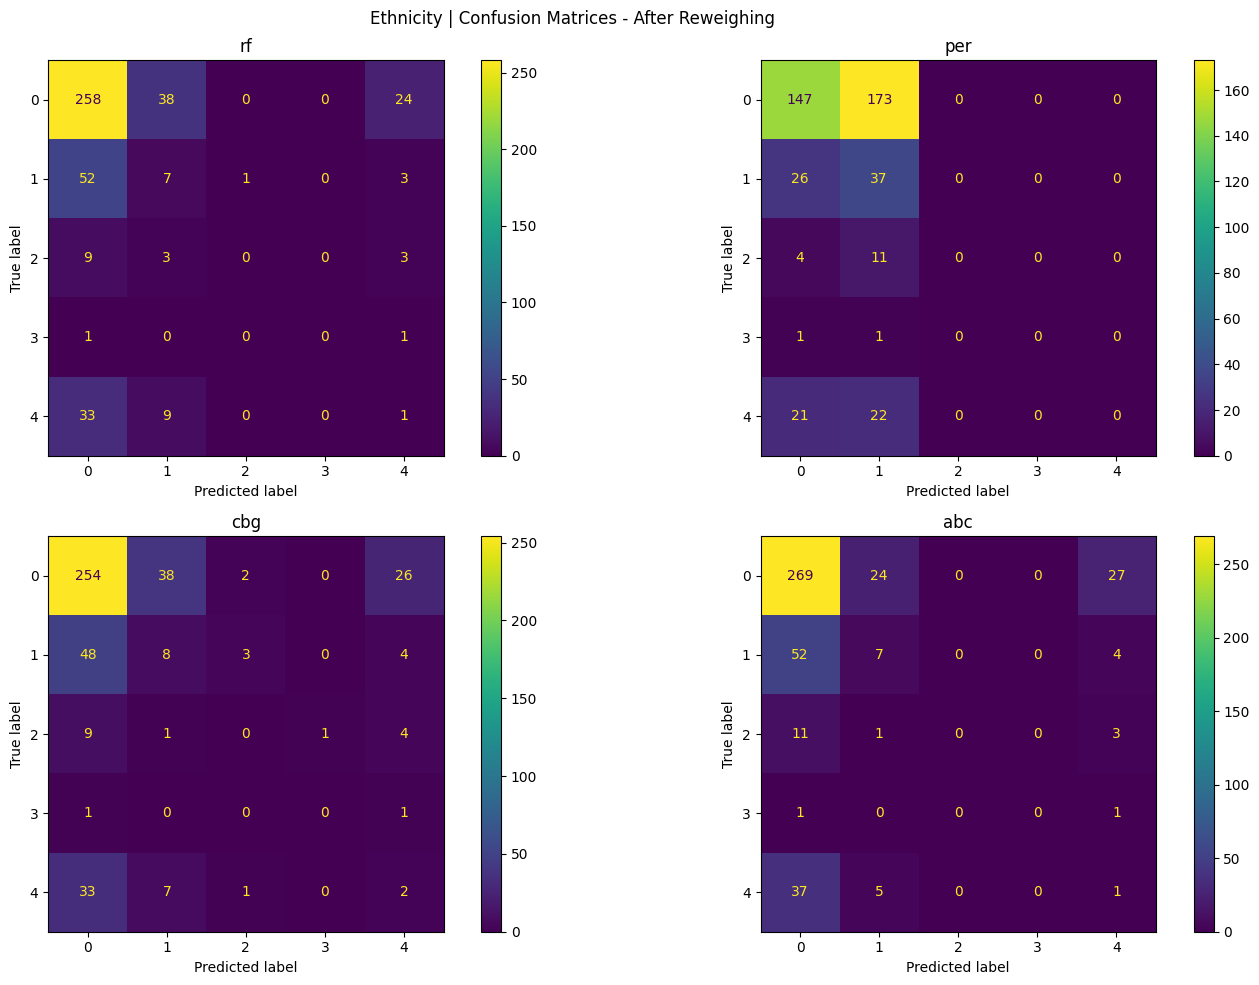

In [29]:
# Confusion matrices
plot_conf_matrices(actual=init_targ_test, predicted=eth_rew_pred, suptitle='Ethnicity | Confusion Matrices - After Reweighing')

Again speaking from the initial look, the performance has decreased everso slightly across the board.

In [30]:
# Result without bias mitigation techniques
init_perf_metrics = calc_ml_perf_metrics(actual=init_targ_test, predictions=init_pred)
# Result after reweighing
eth_rew_perf_metrics = calc_ml_perf_metrics(actual=eth_rew_targ_test, predictions=eth_rew_pred)

#### Results in %

,rf,per,cbg,abc
precision,83.81,79.94,83.01,69.61
accuracy,85.10,72.23,84.42,69.75
f1-Score,83.32,60.59,83.47,69.47
recall,85.10,72.23,84.42,69.75


#### Results in %

,rf,per,cbg,abc
precision,81.84,75.18,81.61,80.01
accuracy,85.10,44.02,83.75,80.59
f1-Score,82.98,48.06,82.38,77.37
recall,85.10,44.02,83.75,80.59


Renaming the index column to "measure"


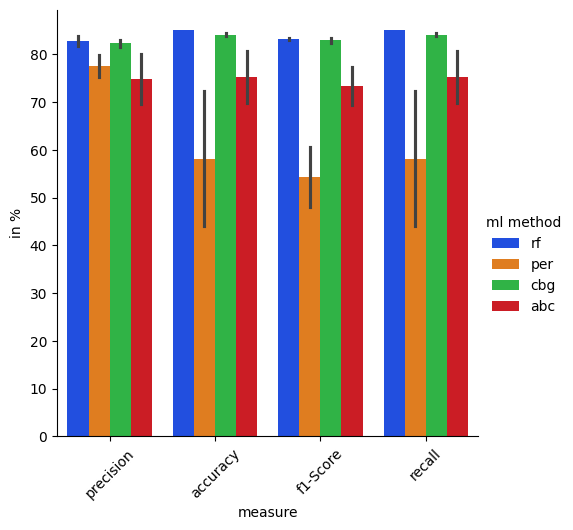

In [31]:
# Plotted
init_perf_metrics_df = pd.DataFrame.from_dict(init_perf_metrics)
eth_rew_perf_metrics_df = pd.DataFrame.from_dict(eth_rew_perf_metrics)
eth_rew_init_ml_perf_comp_df = pd.concat([init_perf_metrics_df, eth_rew_perf_metrics_df], axis=0)
plot_grouped_barchart(data=eth_rew_init_ml_perf_comp_df, index_col='measure', y_col='in %', stack_name='ml method')

As suspected, overall performance has declined. It is worth noting that the Perceptron shows the greatest disparity. Interestingly, especially for the Random Forest, the results hardly changed. Let's see how the bias metrics have changed.

In [32]:
# Eth - Original Result
display(Markdown('### Original Results'))
initial_bias_metrics = calc_bin_label_metrics(dataset=eth_ds, priv_group=eth_priv_group, unpriv_group=eth_unpriv_group, display_results=True)
# Eth - Results after reweighing
display(Markdown('### Results after Reweighing'))
eth_rew_bias_metrics = calc_bin_label_metrics(dataset=eth_rew_res, priv_group=eth_priv_group, unpriv_group=eth_unpriv_group, display_results=True)

### Original Results

**Disparate Impact Ratio:** ***0.0 %***

**Statistical Parity Difference:** ***-1.0***

**Similarity of Data:** ***92.0 %***

**Smoothed Empirical Difference Fairness:** ***1.1***

### Results after Reweighing

**Disparate Impact Ratio:** ***0.0 %***

**Statistical Parity Difference:** ***-1.0***

**Similarity of Data:** ***92.0 %***

**Smoothed Empirical Difference Fairness:** ***0.72***

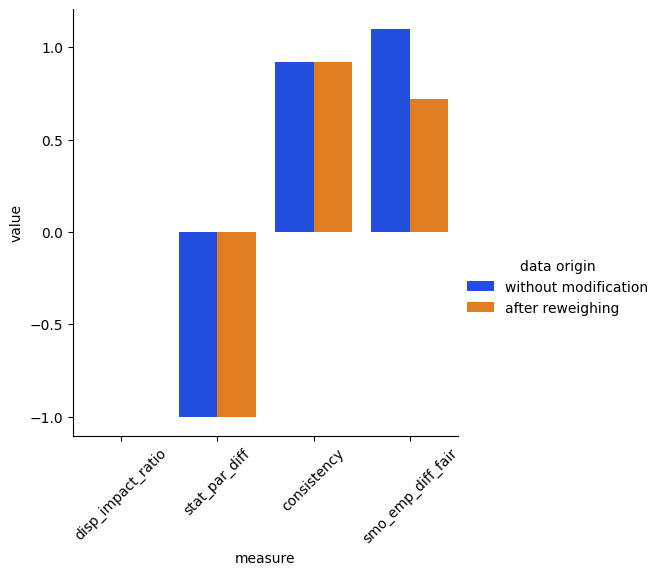

In [33]:
# And the according visualization
# initial_bias_metrics_df = pd.DataFrame.from_dict(initial_bias_metrics)
eth_rew_to_conv = {'without modification': initial_bias_metrics,
               'after reweighing': eth_rew_bias_metrics}

eth_rew_bias_comp_df = pd.DataFrame.from_dict(eth_rew_to_conv).reset_index()
eth_rew_bias_comp_df = eth_rew_bias_comp_df.rename(columns={'index': 'measure'})
eth_rew_bias_comp_df = eth_rew_bias_comp_df.set_index('measure')
eth_rew_bias_comp_df = eth_rew_bias_comp_df.stack().to_frame('value').reset_index()
eth_rew_bias_comp_df = eth_rew_bias_comp_df.rename(columns={'level_1': 'data origin'})

init_per_plot = sns.catplot(data=eth_rew_bias_comp_df, x='measure', y='value', hue='data origin', kind='bar', palette='bright')
init_per_plot.set_xticklabels(rotation=45)
plt.show()

Not much has changed, apart from a slight decrease between the data distributions to compensate for empirical differences.

## Ethnicity - Inprocessing <a name="eth_inproc"></a>

As briefly introduced before, for inprocessing, we use the [Adversarial Debiasing](#adv_deb) techinque. AAdversarial debiasing aims to train to accurately classify the target while simultaneously training a "discriminator" to predict the protected attribute based on the result of the training cycles. The objective is to reduce the performance of the discriminator so that it cannot predict the favourable or unfavourable group reliably anymore [11]. Moreover, Adversarial Debiasing requires active training epochs to work. Thus, we follow the example provided by the developers of aif360 and create a Tensorflow session.

In [36]:
# Inprocessing requires a bit more preparation. As it works during training, we already need train-test splits beforehand.
eth_ds_train, eth_ds_test = eth_ds.split(num_or_size_splits=[0.2], shuffle=False) # Data shuffling is switched off for reproducibility

# Note, apparently only one group is allowed for adversarial debiasing
eth_priv_group = [{'pctBlack': 1 }]
eth_unpriv_group = [{'pctBlack': 0}]

# Start the tensorflow sesssion
tf.reset_default_graph()
sess = tf.Session()

eth_adv_deb = AdversarialDebiasing(privileged_groups=eth_priv_group,
                    unprivileged_groups=eth_unpriv_group,
                    scope_name='eth_adv_classifier',
                    debias=True,
                    sess=sess)

eth_adv_deb_fitted = eth_adv_deb.fit(eth_ds_train) # Note: we use the unmodified dataset again
eth_adv_deb_predicted = eth_adv_deb_fitted.predict(eth_ds_test)

# And close the session
sess.close()

epoch 0; iter: 0; batch classifier loss: 598644.187500; batch adversarial loss: 0.704552
epoch 1; iter: 0; batch classifier loss: 212699.343750; batch adversarial loss: 0.747115
epoch 2; iter: 0; batch classifier loss: 202343.546875; batch adversarial loss: 0.806707
epoch 3; iter: 0; batch classifier loss: 48759.242188; batch adversarial loss: 0.826987
epoch 4; iter: 0; batch classifier loss: 61585.726562; batch adversarial loss: 0.823493
epoch 5; iter: 0; batch classifier loss: 82896.976562; batch adversarial loss: 0.826236
epoch 6; iter: 0; batch classifier loss: 81905.601562; batch adversarial loss: 0.820424
epoch 7; iter: 0; batch classifier loss: 100115.187500; batch adversarial loss: 0.818223
epoch 8; iter: 0; batch classifier loss: 60167.226562; batch adversarial loss: 0.808471
epoch 9; iter: 0; batch classifier loss: 90524.281250; batch adversarial loss: 0.806406
epoch 10; iter: 0; batch classifier loss: 18679.824219; batch adversarial loss: 0.791914
epoch 11; iter: 0; batch cl

Result after Adversarial Debiasing:

In [38]:

# Note: We use the train-targets from the train-test split here again, as the sample size (mostly - difference of 1 row) 
# matches and the data is unmodified
eth_adv_deb_preds_df = eth_adv_deb_predicted.convert_to_dataframe()[0] #[: 519]

eth_adv_deb_pred = classify_data(train_data=eth_adv_deb_preds_df, train_targets=eth_rew_targ_train, to_predict=eth_rew_ft_test, techniques='all')

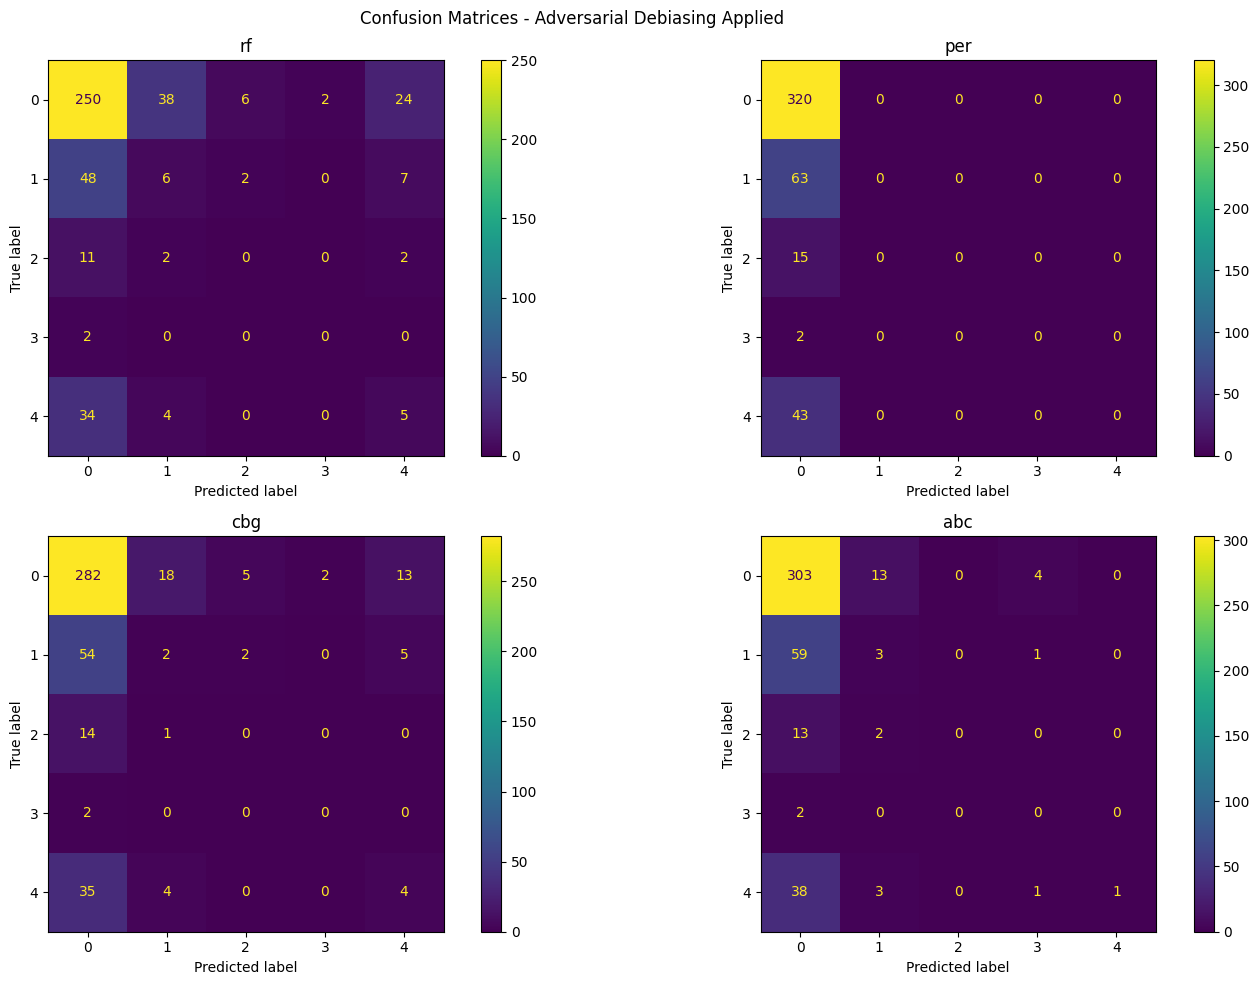

In [39]:
# Confusion matrices after Adversarial Debiasing
plot_conf_matrices(actual=init_targ_test, predicted=eth_adv_deb_pred, suptitle='Confusion Matrices - Adversarial Debiasing Applied')

These results appear better than before the reweighing. But we should check the actual numbers.

In [40]:
# Result without bias mitigation techniques
init_perf_metrics = calc_ml_perf_metrics(actual=init_targ_test, predictions=init_pred)
# Result after Adversarial Debiasing
eth_adv_deb_perf_metrics = calc_ml_perf_metrics(actual=eth_rew_targ_test, predictions=eth_adv_deb_pred)

#### Results in %

,rf,per,cbg,abc
precision,83.81,79.94,83.01,69.61
accuracy,85.10,72.23,84.42,69.75
f1-Score,83.32,60.59,83.47,69.47
recall,85.10,72.23,84.42,69.75


#### Results in %

,rf,per,cbg,abc
precision,58.25,80.78,59.14,59.30
accuracy,60.95,74.04,67.04,69.07
f1-Score,59.56,63.00,62.34,61.11
recall,60.95,74.04,67.04,69.07


Renaming the index column to "measure"


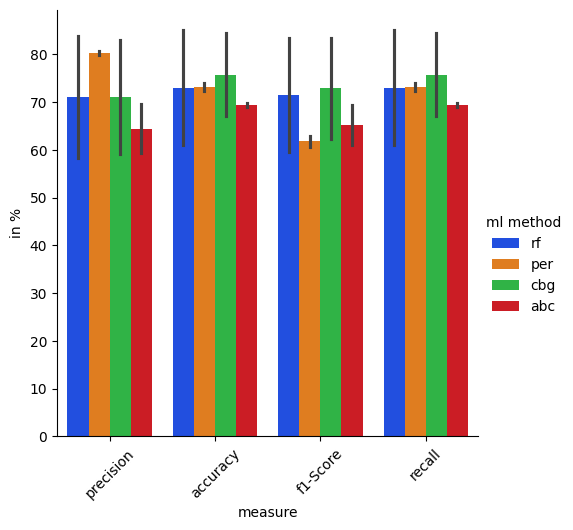

In [41]:
# And the barchart
eth_adv_deb_perf_metrics_df = pd.DataFrame.from_dict(eth_adv_deb_perf_metrics)
eth_adv_deb_init_ml_perf_comp_df = pd.concat([eth_adv_deb_perf_metrics_df, init_perf_metrics_df], axis=0)
plot_grouped_barchart(data=eth_adv_deb_init_ml_perf_comp_df, index_col='measure', y_col='in %', stack_name='ml method')

In fact, most of the models showed a significant drop in performance. The only exception was the Perceptron, which showed a slight increase in performance. Next, we chek the bias metrics after applying the Adversarial Debiasing technique.

In [42]:
# Original Result
display(Markdown('### Original Results'))
initial_bias_metrics = calc_bin_label_metrics(dataset=eth_ds, priv_group=eth_priv_group, unpriv_group=eth_unpriv_group, display_results=True)
# Results after adversarial debiasing
display(Markdown('### Results after Adversarial Debiasing'))
eth_adv_deb_bias_metrics = calc_bin_label_metrics(dataset=eth_adv_deb_predicted, priv_group=eth_priv_group, 
                                                  unpriv_group=eth_unpriv_group, display_results=True)

### Original Results

**Disparate Impact Ratio:** ***0.0 %***

**Statistical Parity Difference:** ***-1.0***

**Similarity of Data:** ***92.0 %***

**Smoothed Empirical Difference Fairness:** ***1.1***

### Results after Adversarial Debiasing

**Disparate Impact Ratio:** ***100.0 %***

**Statistical Parity Difference:** ***0.0***

**Similarity of Data:** ***100.0 %***

**Smoothed Empirical Difference Fairness:** ***0.0***

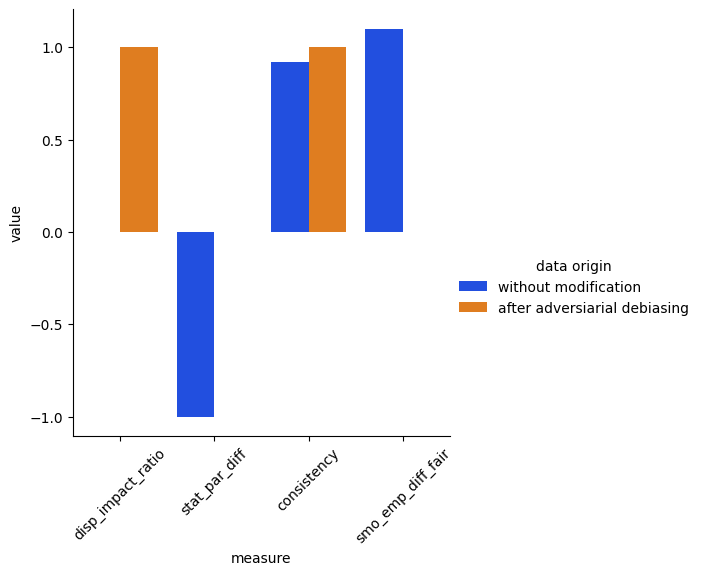

In [43]:
# + plot
eth_adv_deb_to_conv = {'without modification': initial_bias_metrics,
               'after adversiarial debiasing': eth_adv_deb_bias_metrics}

eth_adv_deb_bias_comp_df = pd.DataFrame.from_dict(eth_adv_deb_to_conv).reset_index()
eth_adv_deb_bias_comp_df = eth_adv_deb_bias_comp_df.rename(columns={'index': 'measure'})
eth_adv_deb_bias_comp_df = eth_adv_deb_bias_comp_df.set_index('measure')
eth_adv_deb_bias_comp_df = eth_adv_deb_bias_comp_df.stack().to_frame('value').reset_index()
eth_adv_deb_bias_comp_df = eth_adv_deb_bias_comp_df.rename(columns={'level_1': 'data origin'})

init_per_plot = sns.catplot(data=eth_adv_deb_bias_comp_df, x='measure', y='value', hue='data origin', kind='bar', palette='bright')
init_per_plot.set_xticklabels(rotation=45)
plt.show()

The bias metrics look almost perfect. The Disparate Impact Ratio shows no difference between the privileged and the unprivileged group. Moreover, the differences within the characteristics are supposedly completely eliminated. Finally, complete data consitency has apparently been achieved.

## Ethnicity - Postprocessing <a name="eth_postproc"></a>

Finally, the last set of mitigation techniques is applied after training to the prediction results via [Calibrated Equalised Odds](#cal_eq_oods). This technique aims to opimize the classifier score by adapting the prediction output [12]. Unlike the first two sets of mitigation techniques, a dataset containing processed data is required in addition to the base dataset. Therefore, we will use the result of the adversarial debiasing technique. As the name suggests, pos-processing usually implies that the training is done and is only applied to predictions. Therefore, we will only look at the final bias metrics.

In [44]:
eth_post_inst = CalibratedEqOddsPostprocessing(unprivileged_groups=eth_unpriv_group,
                                                privileged_groups=eth_priv_group)

eth_post_predicted = eth_post_inst.fit_predict(dataset_pred=eth_adv_deb_predicted, dataset_true=eth_ds_test)

In [45]:
# Original Result
display(Markdown('### Original Results'))
initial_bias_metrics = calc_bin_label_metrics(dataset=eth_ds, priv_group=eth_priv_group, unpriv_group=eth_unpriv_group, display_results=True)
# Results after postprocessing
display(Markdown('### Results after calibrated equalized odds'))
eth_post_bias_metrics = calc_bin_label_metrics(dataset=eth_post_predicted, priv_group=eth_priv_group, 
                                               unpriv_group=eth_unpriv_group, display_results=True)

### Original Results

**Disparate Impact Ratio:** ***0.0 %***

**Statistical Parity Difference:** ***-1.0***

**Similarity of Data:** ***92.0 %***

**Smoothed Empirical Difference Fairness:** ***1.1***

### Results after calibrated equalized odds

**Disparate Impact Ratio:** ***100.0 %***

**Statistical Parity Difference:** ***0.0***

**Similarity of Data:** ***100.0 %***

**Smoothed Empirical Difference Fairness:** ***0.0***

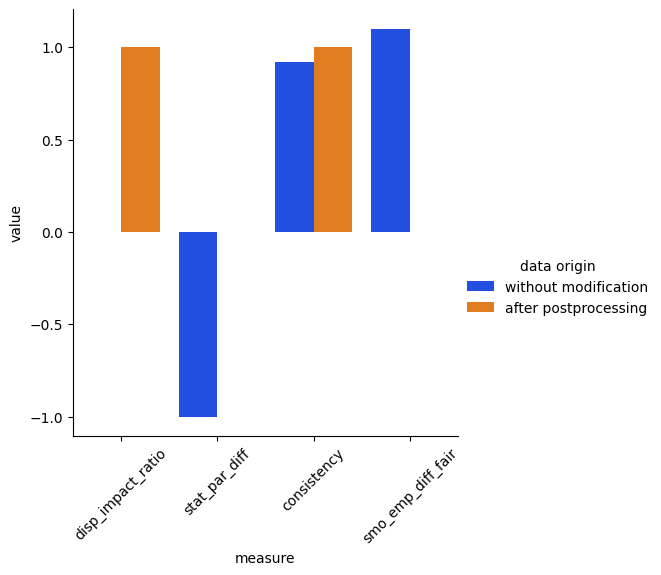

In [46]:
# + plot
eth_post_to_conv = {'without modification': initial_bias_metrics,
               'after postprocessing': eth_post_bias_metrics}

eth_post_comp_df = pd.DataFrame.from_dict(eth_post_to_conv).reset_index()
eth_post_comp_df = eth_post_comp_df.rename(columns={'index': 'measure'})
eth_post_comp_df = eth_post_comp_df.set_index('measure')
eth_post_comp_df = eth_post_comp_df.stack().to_frame('value').reset_index()
eth_post_comp_df = eth_post_comp_df.rename(columns={'level_1': 'data origin'})

init_per_plot = sns.catplot(data=eth_post_comp_df, x='measure', y='value', hue='data origin', kind='bar', palette='bright')
init_per_plot.set_xticklabels(rotation=45)
plt.show()

As shown above, applying postprocessing made no difference after application in this case.

## Summary - Ethnicity as protected attribute <a name="eth_sum"></a>

In the following heatmap each of the results can be observed. Please note, that for the ml performance metrics, only the results from the Random Forests are displayed, as this is the ml technique used for the `Fairlearn` section as well.

In [47]:
fin_eth_init_perf_met = init_perf_metrics_df['rf']
fin_eth_init_perf_met['stage'] = 'without modification'
fin_eth_rew_metr = eth_rew_perf_metrics_df['rf']
fin_eth_rew_metr['stage'] = 'after reweighing'
fin_eth_adv_deb_metr = eth_adv_deb_perf_metrics_df['rf']
fin_eth_adv_deb_metr['stage'] = 'after adversarial debiasing'
eth_fin_ml_per_df = pd.DataFrame([fin_eth_init_perf_met, fin_eth_rew_metr, fin_eth_adv_deb_metr]).reset_index()
eth_fin_ml_per_df = eth_fin_ml_per_df.drop(columns='index').set_index('stage')
eth_fin_ml_per_df

,precision,accuracy,f1-Score,recall
stage,,,,
without modification,83.81,85.10,83.32,85.10
after reweighing,81.84,85.10,82.98,85.10
after adversarial debiasing,58.25,60.95,59.56,60.95


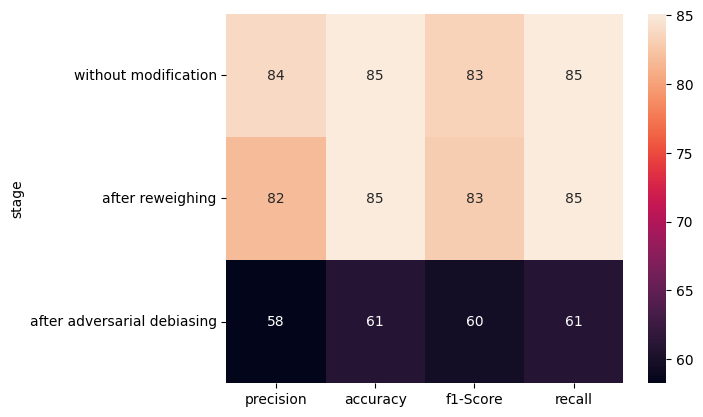

In [48]:
eth_fin_ml_plot= sns.heatmap(data=eth_fin_ml_per_df, annot=True)
plt.show()

And the result of the bias mitigation techniques:

In [49]:
eth_fin_bias_metrics = {'without modification': initial_bias_metrics,
                        'after reweighing': eth_rew_bias_metrics,
                        'after adversarial debiasing': eth_adv_deb_bias_metrics,
                        'after  calculating equalized odds': eth_post_bias_metrics
                    }

eth_fin_bias_metrics_df = pd.DataFrame.from_dict(eth_fin_bias_metrics)
eth_fin_bias_metrics_df

,without modification,after reweighing,after adversarial debiasing,after calculating equalized odds
disp_impact_ratio,0.00,0.00,1.0,1.0
stat_par_diff,-1.00,-1.00,0.0,0.0
consistency,0.92,0.92,1.0,1.0
smo_emp_diff_fair,1.10,0.72,0.0,0.0


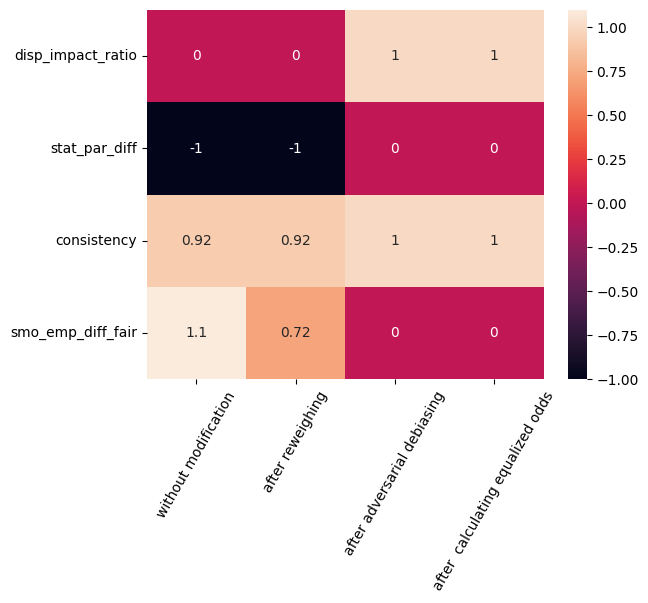

In [50]:
eth_fin_bias_plot = sns.heatmap(data=eth_fin_bias_metrics_df, annot=True)
eth_fin_bias_plot.set_xticklabels(labels=eth_fin_bias_metrics_df[: 0], rotation=60)
plt.show()

## Violence Prediction Dataset - Single Parent Households (Par) <a name="par_title"></a>

As a next step, we want to check whether different results are obtained when using a different protected attribute. For this check we use the hypothesis that single parent households are connotated with negative bias. First, we check the possible values of Dalc and the distribution.

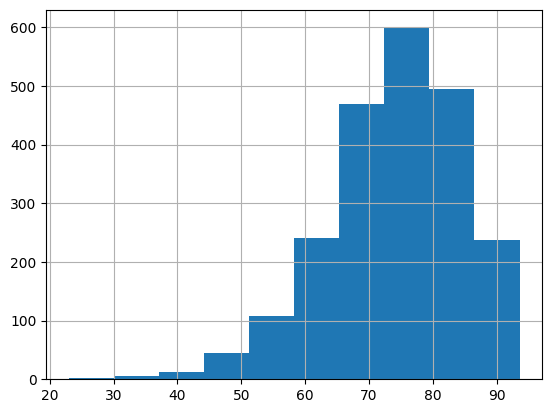

In [52]:
# Check all possible values of Dalc
cleaned['pct2Par'].unique()
cleaned['pct2Par'].hist()
plt.show()

As can be seen from the graph, most families have both parents living in the same household. To check how the bias affects lone parent households, we set the threshold at places where less than 60% of children live in a household where both parents are present.

In [53]:
# Define the favourable & unvafourable group
par_priv_group = [{'pct2Par': 1}]
par_unpriv_group = [{'pct2Par': 0}]

In [57]:
# Instantiate the dataset with dalc as protected attribute. 
# # Furthermore, we drop the age to see distinct results compared to the first section
par_ds = StandardDataset(df=cleaned,
                    label_name='pct2Par',
                    protected_attribute_names=['pct2Par'],
                    favorable_classes=[1],
                    privileged_classes=[lambda x: 1 if x >= 60 else 0]
                    )

Similarly to the age, we check the initial bias metrics first.

In [58]:
# Bias metrics Dalc wihtout modifications
par_initial_metrics = calc_bin_label_metrics(dataset=par_ds, priv_group=par_priv_group, unpriv_group=par_unpriv_group, display_results=True)

**Disparate Impact Ratio:** ***0.0 %***

**Statistical Parity Difference:** ***-1.0***

**Similarity of Data:** ***90.0 %***

**Smoothed Empirical Difference Fairness:** ***8.29***

Again, we see similar initial metrics. However, this time the difference in empirical fairness is significantly higher.

## Par - Preprocessing <a name="par_preproc"> </a>

In [62]:
par_rew_inst = Reweighing(unprivileged_groups=par_unpriv_group, privileged_groups=par_priv_group)
par_rew_fit = par_rew_inst.fit(par_ds)
par_rew_res = par_rew_fit.transform(par_ds)

In [63]:
display(HTML(par_rew_res .convert_to_dataframe()[0].head(10).to_html()))

,pop,perHoush,pctBlack,pctWhite,pctAsian,pctHisp,pct12-21,pct12-29,pct16-24,pct65up,persUrban,pctUrban,medIncome,pctWwage,pctWfarm,pctWdiv,pctWsocsec,pctPubAsst,pctRetire,medFamIncome,perCapInc,whitePerCap,blackPerCap,NAperCap,asianPerCap,otherPerCap,hispPerCap,persPoverty,pctPoverty,pctLowEdu,pctNotHSgrad,pctCollGrad,pctUnemploy,pctEmploy,pctEmployMfg,pctEmployProfServ,pctOccupManu,pctOccupMgmt,pctMaleDivorc,pctMaleNevMar,pctFemDivorc,pctAllDivorc,persPerFam,pctKids2Par,pctKids-4w2Par,pct12-17w2Par,pctWorkMom-6,pctWorkMom-18,kidsBornNevrMarr,pctKidsBornNevrMarr,numForeignBorn,pctFgnImmig-3,pctFgnImmig-5,pctFgnImmig-8,pctFgnImmig-10,pctImmig-3,pctImmig-5,pctImmig-8,pctImmig-10,pctSpeakOnlyEng,pctNotSpeakEng,pctLargHousFam,pctLargHous,persPerOccupHous,persPerOwnOccup,persPerRenterOccup,pctPersOwnOccup,pctPopDenseHous,pctSmallHousUnits,medNumBedrm,houseVacant,pctHousOccup,pctHousOwnerOccup,pctVacantBoarded,pctVacant6up,medYrHousBuilt,pctHousWOphone,pctHousWOplumb,ownHousLowQ,ownHousMed,ownHousUperQ,ownHousQrange,rentLowQ,rentMed,rentUpperQ,rentQrange,medGrossRent,medRentpctHousInc,medOwnCostpct,medOwnCostPctWO,persEmergShelt,persHomeless,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,numPolice,policePerPop,policeField,policeFieldPerPop,policeCalls,policCallPerPop,policCallPerOffic,policePerPop2,racialMatch,pctPolicWhite,pctPolicBlack,pctPolicHisp,pctPolicAsian,pctPolicMinority,officDrugUnits,numDiffDrugsSeiz,policAveOT,landArea,popDensity,pctUsePubTrans,policCarsAvail,policOperBudget,pctPolicPatrol,gangUnit,pctOfficDrugUnit,policBudgetPerPop,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_NC,State_ND,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,pct2Par
0,11980.0,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980.0,100.0,75122.0,89.24,1.55,70.20,23.62,1.03,18.39,79584.0,29711.0,30233.0,13600.0,5725.0,27101.0,5115.0,22838.0,227.0,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,5.22,4.47,3.22,90.17,95.78,95.81,44.56,58.88,31.0,0.36,1277.0,8.69,13.00,20.99,30.93,0.93,1.39,2.24,3.30,85.68,1.37,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3.0,64.0,98.37,91.01,3.12,37.50,1959.0,0.00,0.28,215900.0,262600.0,326900.0,111000.0,685.0,1001.0,1001.0,316.0,1001.0,23.8,21.1,14.0,11.0,0.0,10.66,53.72,65.29,78.09,89.14,173.0,196.00,152.0,170.00,90000.0,91035.0,443.0,196.0,88.00,86.00,5.00,2.00,0.0,11.00,12.0,9.0,99.0,6.5,1845.9,9.63,86.0,11164110.0,90.00,5.0,0.00,114582.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,23123.0,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123.0,100.0,47917.0,78.99,1.11,64.11,35.50,2.75,22.85,55323.0,20148.0,20191.0,18137.0,0.0,20074.0,5250.0,12222.0,885.0,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,6.45,5.42,3.11,85.33,96.82,86.46,51.14,62.43,43.0,0.24,1920.0,5.21,8.65,13.33,22.50,0.43,0.72,1.11,1.87,87.79,1.81,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3.0,240.0,97.15,84.88,0.00,18.33,1958.0,0.31,0.14,136300.0,164200.0,199900.0,63600.0,467.0,560.0,672.0,205.0,627.0,27.6,20.7,12.5,0.0,0.0,8.30,77.17,71.27,90.22,96.12,173.0,196.00,152.0,170.00,90000.0,91035.0,443.0,196.0,88.00,86.00,5.00,2.00,0.0,11.00,12.0,9.0,99.0,10.6,2186.7,3.84,86.0,11164110.0,90.00,5.0,0.00,114582.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,29344.0,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344.0,100.0,35669.0,82.00,1.15,55.73,22.25,

In [64]:
# Determine training- and test-data
par_rew_df = par_rew_res.convert_to_dataframe()[0]
par_rew_ft_train, par_rew_ft_test, par_rew_targ_train, par_rew_targ_test = train_test_split(par_rew_df, targ, test_size=0.2)

# Predict
par_rew_pred = classify_data(train_data=par_rew_ft_train, train_targets=par_rew_targ_train, to_predict=par_rew_ft_test, techniques='all')

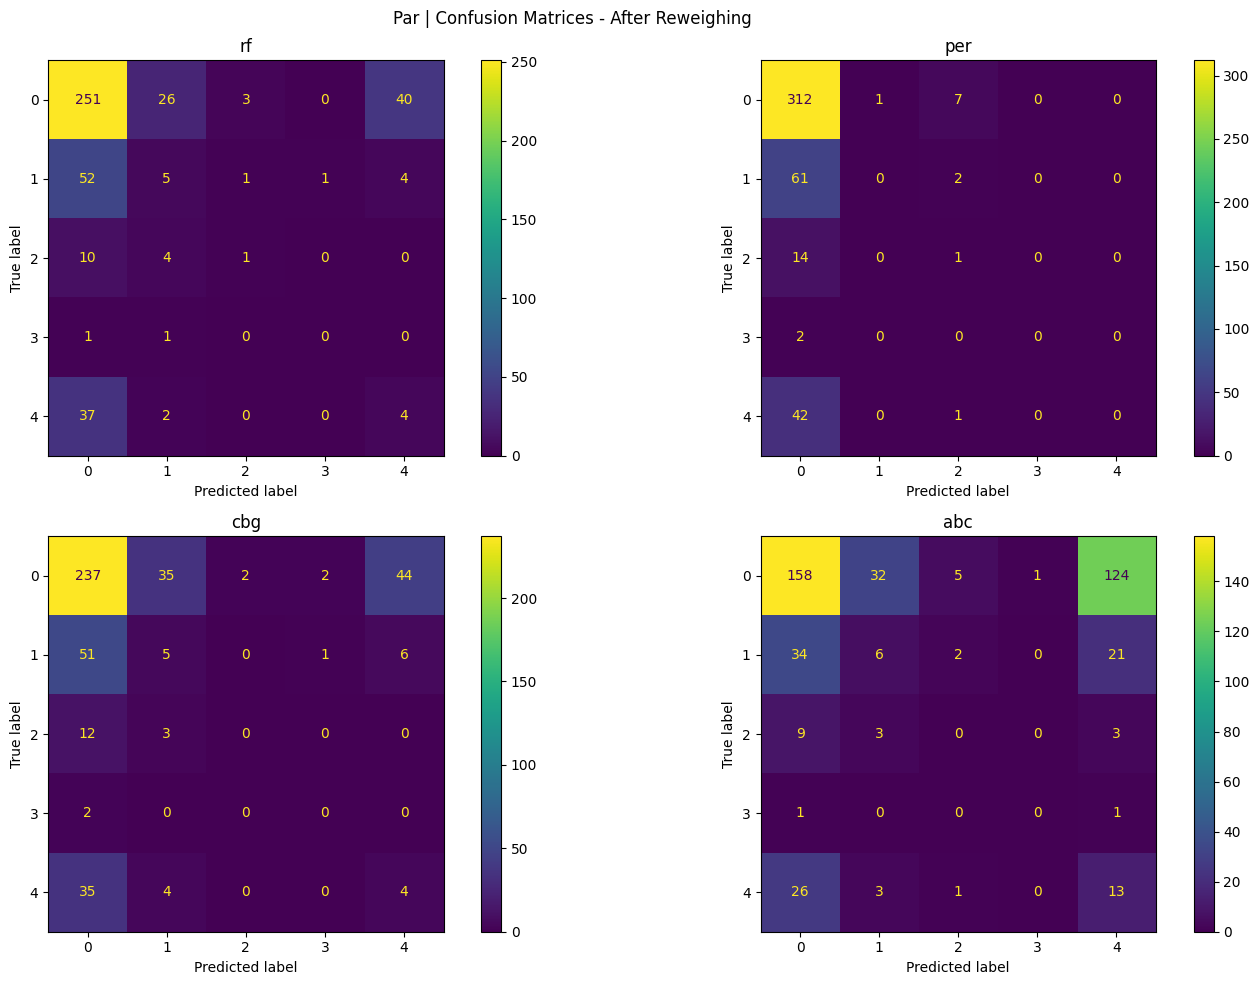

In [66]:
# Confusion matrices
plot_conf_matrices(actual=init_targ_test, predicted=par_rew_pred, suptitle='Par | Confusion Matrices - After Reweighing')

In [67]:
# Result without bias mitigation techniques
init_perf_metrics = calc_ml_perf_metrics(actual=init_targ_test, predictions=init_pred)
# Result after reweighing
par_rew_perf_metrics = calc_ml_perf_metrics(actual=par_rew_targ_test, predictions=par_rew_pred)

#### Results in %

,rf,per,cbg,abc
precision,83.81,79.94,83.01,69.61
accuracy,85.10,72.23,84.42,69.75
f1-Score,83.32,60.59,83.47,69.47
recall,85.10,72.23,84.42,69.75


#### Results in %

,rf,per,cbg,abc
precision,80.93,76.41,82.84,58.72
accuracy,83.30,69.07,84.65,51.02
f1-Score,81.05,57.68,82.79,52.42
recall,83.30,69.07,84.65,51.02


Renaming the index column to "measure"


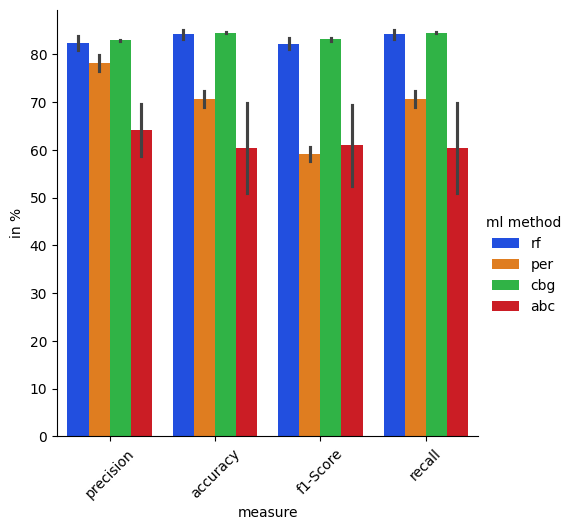

In [68]:
init_perf_metrics_df = pd.DataFrame.from_dict(init_perf_metrics)
par_rew_perf_metrics_df = pd.DataFrame.from_dict(par_rew_perf_metrics)
par_rew_init_ml_perf_comp_df = pd.concat([init_perf_metrics_df, par_rew_perf_metrics_df], axis=0)
plot_grouped_barchart(data=par_rew_init_ml_perf_comp_df, index_col='measure', y_col='in %', stack_name='ml method')

Overall, reweighing lead to slightly worse results this time.

In [70]:
# Original Result
display(Markdown('### Par - Original Results'))
par_initial_bias_metrics = calc_bin_label_metrics(dataset=par_ds, priv_group=par_priv_group, 
                                            unpriv_group=par_unpriv_group, display_results=True)
# Results after reweighing
display(Markdown('### Par - Results after Reweighing'))
par_rew_bias_metrics = calc_bin_label_metrics(dataset=par_rew_res, priv_group=par_priv_group, 
                                            unpriv_group=par_unpriv_group, display_results=True)

### Par - Original Results

**Disparate Impact Ratio:** ***0.0 %***

**Statistical Parity Difference:** ***-1.0***

**Similarity of Data:** ***90.0 %***

**Smoothed Empirical Difference Fairness:** ***8.29***

### Par - Results after Reweighing

**Disparate Impact Ratio:** ***0.0 %***

**Statistical Parity Difference:** ***-1.0***

**Similarity of Data:** ***90.0 %***

**Smoothed Empirical Difference Fairness:** ***8.17***

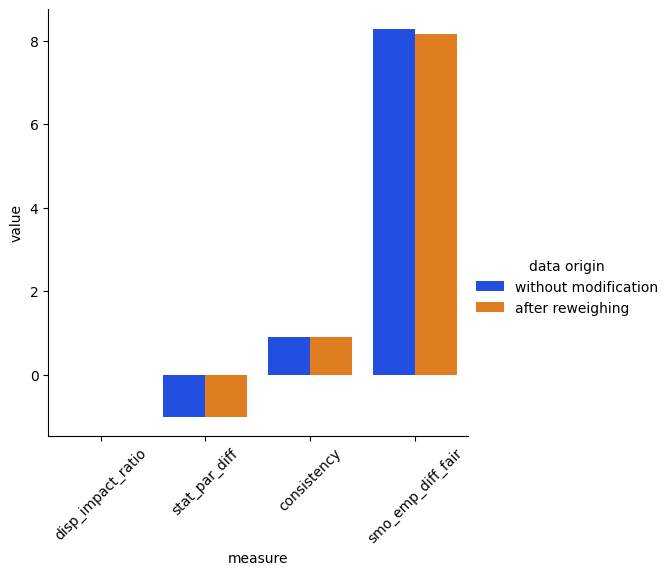

In [71]:
# And the according visualization
par_rew_to_conv = {'without modification': par_initial_bias_metrics,
               'after reweighing': par_rew_bias_metrics}

par_rew_bias_comp_df = pd.DataFrame.from_dict(par_rew_to_conv).reset_index()
par_rew_bias_comp_df = par_rew_bias_comp_df.rename(columns={'index': 'measure'})
par_rew_bias_comp_df = par_rew_bias_comp_df.set_index('measure')
par_rew_bias_comp_df = par_rew_bias_comp_df.stack().to_frame('value').reset_index()
par_rew_bias_comp_df = par_rew_bias_comp_df.rename(columns={'level_1': 'data origin'})

init_per_plot = sns.catplot(data=par_rew_bias_comp_df, x='measure', y='value', hue='data origin', kind='bar', palette='bright')
init_per_plot.set_xticklabels(rotation=45)
plt.show()

The results of the bias metrics remained largely identical. The empirical difference was slightly reduced.

## Par - Inprocessing <a name="par_inproc"></a>

In [72]:
par_ds_train, par_ds_test = par_ds.split(num_or_size_splits=[0.2], shuffle=False) # Data shuffling is turned of for reproducibility purposes

# Start the tensorflow sesssion
tf.reset_default_graph()
sess = tf.Session()

par_adv_deb = AdversarialDebiasing(privileged_groups =par_priv_group,
                    unprivileged_groups=par_unpriv_group,
                    scope_name='par_adv_classifier',
                    debias=True,
                    sess=sess)

par_adv_deb_fitted = par_adv_deb.fit(par_ds_train) # Note: we use the unmodified dataset again
par_adv_deb_predicted = par_adv_deb_fitted.predict(par_ds_test)

sess.close()

epoch 0; iter: 0; batch classifier loss: 87732.515625; batch adversarial loss: 1.546759
epoch 1; iter: 0; batch classifier loss: 109017.031250; batch adversarial loss: 1.381264
epoch 2; iter: 0; batch classifier loss: 133653.031250; batch adversarial loss: 1.165254
epoch 3; iter: 0; batch classifier loss: 200195.890625; batch adversarial loss: 1.161269
epoch 4; iter: 0; batch classifier loss: 144123.609375; batch adversarial loss: 1.224541
epoch 5; iter: 0; batch classifier loss: 235763.312500; batch adversarial loss: 1.279852
epoch 6; iter: 0; batch classifier loss: 359073.031250; batch adversarial loss: 1.407660
epoch 7; iter: 0; batch classifier loss: 70372.164062; batch adversarial loss: 1.446110
epoch 8; iter: 0; batch classifier loss: 236558.718750; batch adversarial loss: 1.490651
epoch 9; iter: 0; batch classifier loss: 55825.957031; batch adversarial loss: 1.476420
epoch 10; iter: 0; batch classifier loss: 237302.562500; batch adversarial loss: 1.321252
epoch 11; iter: 0; batc

In [73]:
# Note: We use the train-targets from the train-test split here again, as the sample size (mostly - difference of 1 row) 
# matches and the data is unmodified
par_adv_deb_preds_df = par_adv_deb_predicted.convert_to_dataframe()[0] #[: 519]

par_adv_deb_pred = classify_data(train_data=par_adv_deb_preds_df, train_targets=par_rew_targ_train, 
                                to_predict=par_rew_ft_test, techniques='all')

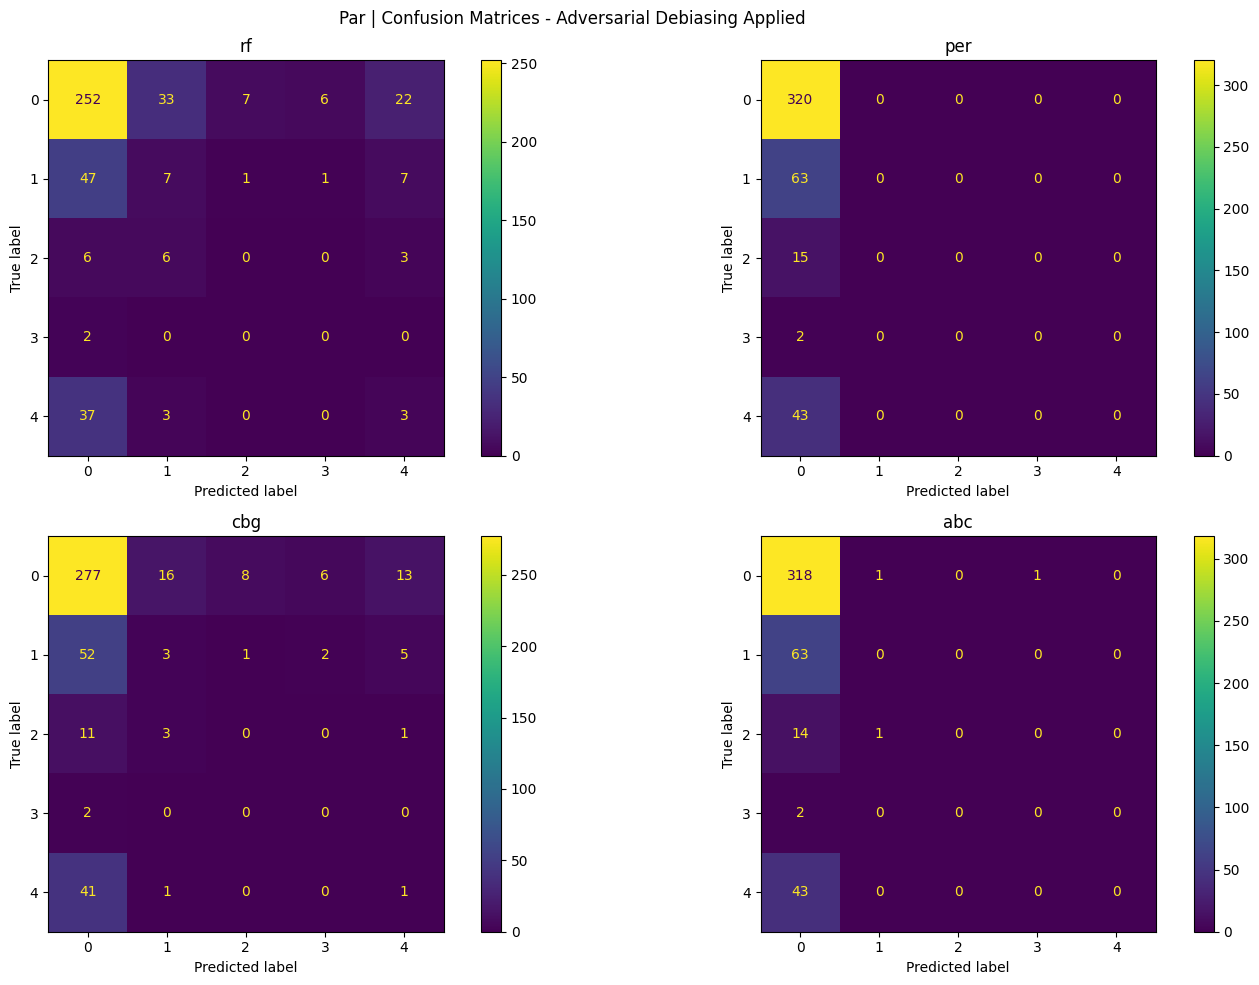

In [74]:
# Confusion matrices for Dalc after Adversarial Debiasing
plot_conf_matrices(actual=init_targ_test, predicted=par_adv_deb_pred, suptitle='Par | Confusion Matrices - Adversarial Debiasing Applied')

In [75]:
# Result without bias mitigation techniques
init_perf_metrics = calc_ml_perf_metrics(actual=init_targ_test, predictions=init_pred)
# Result after Adversarial Debiasing
par_adv_deb_perf_metrics = calc_ml_perf_metrics(actual=par_rew_targ_test, predictions=par_adv_deb_pred)

#### Results in %

,rf,per,cbg,abc
precision,83.81,79.94,83.01,69.61
accuracy,85.10,72.23,84.42,69.75
f1-Score,83.32,60.59,83.47,69.47
recall,85.10,72.23,84.42,69.75


#### Results in %

,rf,per,cbg,abc
precision,50.67,78.55,50.62,64.79
accuracy,55.76,68.85,61.17,68.40
f1-Score,52.92,56.15,54.78,56.00
recall,55.76,68.85,61.17,68.40


Renaming the index column to "measure"


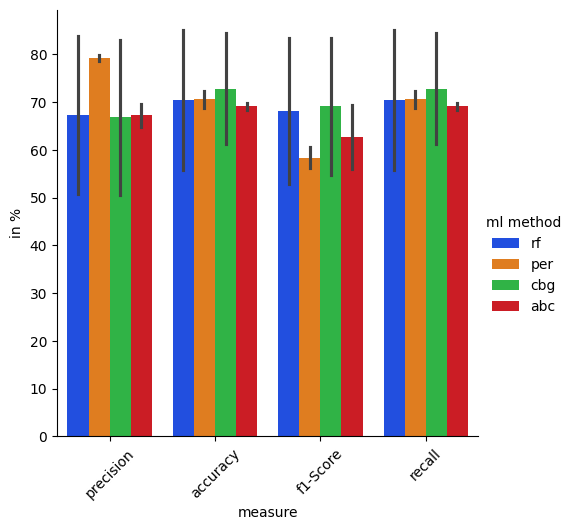

In [76]:
# And the barchart
par_adv_deb_perf_metrics_df = pd.DataFrame.from_dict(par_adv_deb_perf_metrics)
par_adv_deb_init_ml_perf_comp_df = pd.concat([par_adv_deb_perf_metrics_df, init_perf_metrics_df], axis=0)
plot_grouped_barchart(data=par_adv_deb_init_ml_perf_comp_df, index_col='measure', y_col='in %', stack_name='ml method')

This time the results decreased accross the board compared to the reweighing.

In [77]:
# Original Result
display(Markdown('### Par Original Results'))
par_initial_metrics = calc_bin_label_metrics(dataset=par_ds, priv_group=par_priv_group, unpriv_group=par_unpriv_group, display_results=True)
# Results after adversarial debiasing
display(Markdown('### Par - Results after Adversarial Debiasing'))
par_adv_deb_bias_metrics = calc_bin_label_metrics(dataset=par_adv_deb_predicted, priv_group=par_priv_group, 
                                                  unpriv_group=par_unpriv_group, display_results=True)

### Par Original Results

**Disparate Impact Ratio:** ***0.0 %***

**Statistical Parity Difference:** ***-1.0***

**Similarity of Data:** ***90.0 %***

**Smoothed Empirical Difference Fairness:** ***8.29***

### Par - Results after Adversarial Debiasing

**Disparate Impact Ratio:** ***100.0 %***

**Statistical Parity Difference:** ***0.0***

**Similarity of Data:** ***100.0 %***

**Smoothed Empirical Difference Fairness:** ***2.29***

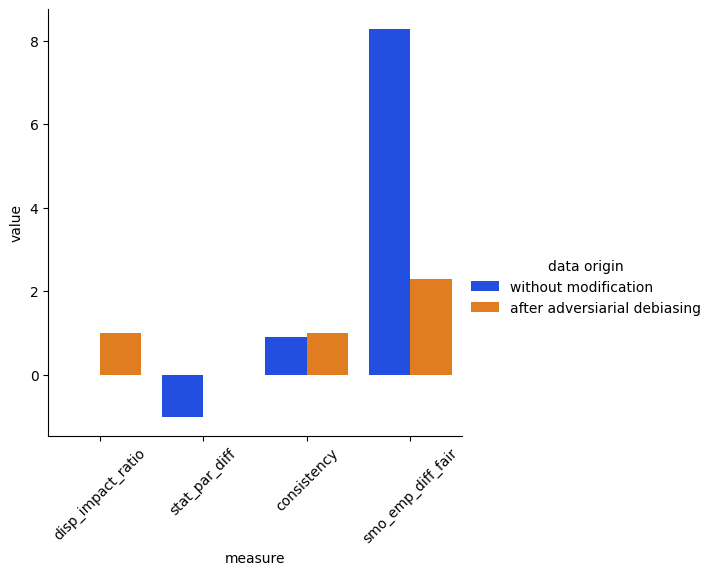

In [78]:
# + plot
par_adv_deb_to_conv = {'without modification': par_initial_metrics,
               'after adversiarial debiasing': par_adv_deb_bias_metrics}

par_adv_deb_bias_comp_df = pd.DataFrame.from_dict(par_adv_deb_to_conv).reset_index()
par_adv_deb_bias_comp_df = par_adv_deb_bias_comp_df.rename(columns={'index': 'measure'})
par_adv_deb_bias_comp_df = par_adv_deb_bias_comp_df.set_index('measure')
par_adv_deb_bias_comp_df = par_adv_deb_bias_comp_df.stack().to_frame('value').reset_index()
par_adv_deb_bias_comp_df = par_adv_deb_bias_comp_df.rename(columns={'level_1': 'data origin'})


init_per_plot = sns.catplot(data=par_adv_deb_bias_comp_df, x='measure', y='value', hue='data origin', kind='bar', palette='bright')
init_per_plot.set_xticklabels(rotation=45)
plt.show()

After applying the adversarial debiasing technique, the bias metrics improved dramatically. The data is again perfectly similar, has no disparate impact, and the fairness of the price differences has been greatly reduced.

## Par - Postprocessing <a name="par_postproc"></a>

In [79]:
par_post_inst = CalibratedEqOddsPostprocessing(unprivileged_groups=par_unpriv_group,
                                                privileged_groups=par_priv_group)

par_post_predicted = par_post_inst.fit_predict(dataset_pred=par_adv_deb_predicted, dataset_true=par_ds_test)

In [80]:
# Dalc - Original Result
display(Markdown('### Original Results'))
par_initial_bias_metrics = calc_bin_label_metrics(dataset=par_ds, priv_group=par_priv_group, 
                                                   unpriv_group=par_unpriv_group, display_results=True)
# Results after postprocessing
display(Markdown('### Results after calibrated equalized odds'))
par_post_bias_metrics = calc_bin_label_metrics(dataset=par_post_predicted, priv_group=par_priv_group, 
                                               unpriv_group=par_unpriv_group, display_results=True)

### Original Results

**Disparate Impact Ratio:** ***0.0 %***

**Statistical Parity Difference:** ***-1.0***

**Similarity of Data:** ***90.0 %***

**Smoothed Empirical Difference Fairness:** ***8.29***

### Results after calibrated equalized odds

**Disparate Impact Ratio:** ***100.0 %***

**Statistical Parity Difference:** ***0.0***

**Similarity of Data:** ***100.0 %***

**Smoothed Empirical Difference Fairness:** ***2.29***

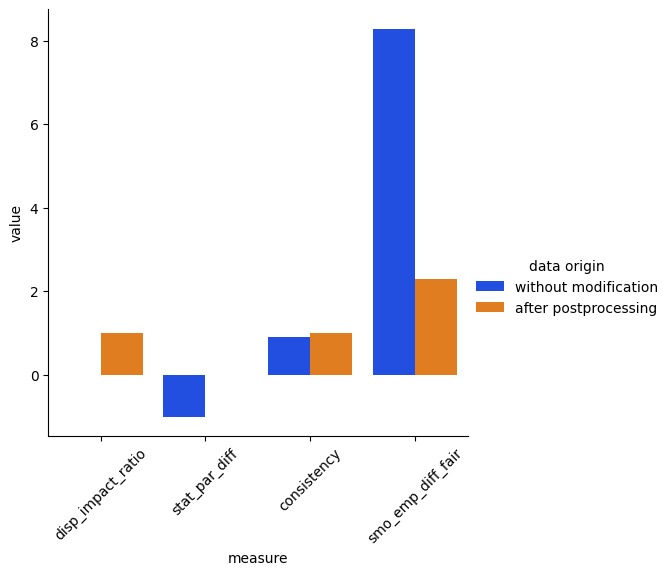

In [81]:
# + plot
par_post_to_conv = {'without modification': par_initial_bias_metrics,
               'after postprocessing': par_post_bias_metrics}

par_post_comp_df = pd.DataFrame.from_dict(par_post_to_conv).reset_index()
par_post_comp_df = par_post_comp_df.rename(columns={'index': 'measure'})
par_post_comp_df = par_post_comp_df.set_index('measure')
par_post_comp_df = par_post_comp_df.stack().to_frame('value').reset_index()
par_post_comp_df = par_post_comp_df.rename(columns={'level_1': 'data origin'})

init_per_plot = sns.catplot(data=par_post_comp_df, x='measure', y='value', hue='data origin', kind='bar', palette='bright')
init_per_plot.set_xticklabels(rotation=45)
plt.show()

Finally, postprocessing had no impact on the prediction results again.

## Summary - Par as Protected Attribute <a name="par_sum"></a>

Mirroring the ethnicity section of the notebook, the following heatmap summarises the performance of the ml techniques with lone parent households as the protected variable, and the corresponding bias metrics.

In [82]:
fin_par_init_perf_met = init_perf_metrics_df['rf']
fin_par_init_perf_met['stage'] = 'without modification'
fin_par_rew_metr = par_rew_perf_metrics_df['rf']
fin_par_rew_metr['stage'] = 'after reweighing'
fin_par_adv_deb_metr = par_adv_deb_perf_metrics_df['rf']
fin_par_adv_deb_metr['stage'] = 'after adversarial debiasing'
par_fin_ml_per_df = pd.DataFrame([fin_par_init_perf_met, fin_par_rew_metr, fin_par_adv_deb_metr]).reset_index()
par_fin_ml_per_df = par_fin_ml_per_df.drop(columns='index').set_index('stage')
par_fin_ml_per_df

,precision,accuracy,f1-Score,recall
stage,,,,
without modification,83.81,85.10,83.32,85.10
after reweighing,80.93,83.30,81.05,83.30
after adversarial debiasing,50.67,55.76,52.92,55.76


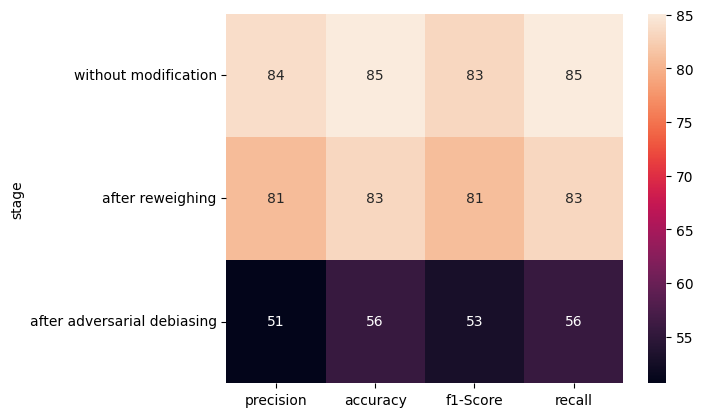

In [83]:
par_fin_ml_plot= sns.heatmap(data=par_fin_ml_per_df, annot=True)
plt.show()

In [86]:
par_fin_bias_metrics = {'without modification': par_initial_bias_metrics,
                        'after reweighing': par_rew_bias_metrics,
                        'after adversarial debiasing': par_adv_deb_bias_metrics,
                        'after  calculating equalized odds': par_post_bias_metrics
                    }

par_fin_bias_metrics_df = pd.DataFrame.from_dict(par_fin_bias_metrics)
par_fin_bias_metrics_df

,without modification,after reweighing,after adversarial debiasing,after calculating equalized odds
disp_impact_ratio,0.00,0.00,1.00,1.00
stat_par_diff,-1.00,-1.00,0.00,0.00
consistency,0.90,0.90,1.00,1.00
smo_emp_diff_fair,8.29,8.17,2.29,2.29


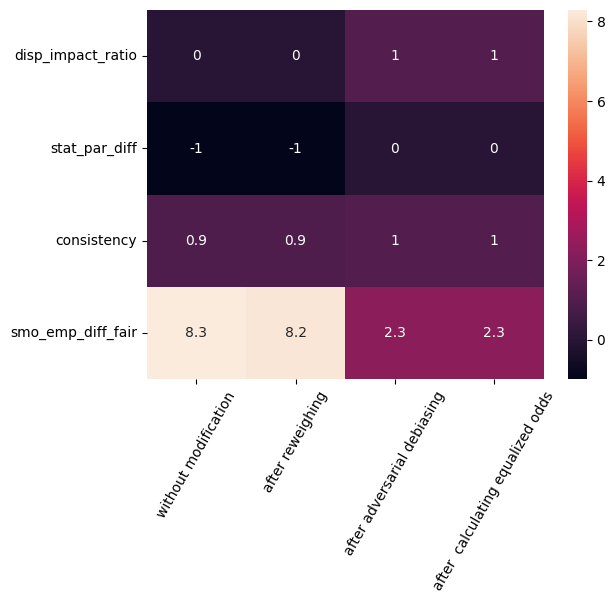

In [87]:
par_fin_bias_plot = sns.heatmap(data=par_fin_bias_metrics_df, annot=True)
par_fin_bias_plot.set_xticklabels(labels=par_fin_bias_metrics_df[: 0], rotation=60)
plt.show()

## Comparison - Ethnicity and Single Parent Households <a name="comp_eth_par"></a>

As final section of this notebook, a quick summary and concluding remarks are provided.

In [88]:
# Prepare the data from Dalc
par_ml_perf_comp = par_fin_ml_per_df.reset_index()
par_ml_perf_comp['prot_attr'] = 'par'

# Perpare the age data
eth_ml_perf_comp = eth_fin_ml_per_df.reset_index()
eth_ml_perf_comp['prot_attr'] = 'eth'
eth_ml_perf_comp

ml_per_comp = pd.concat([eth_ml_perf_comp, par_ml_perf_comp], axis=0).reset_index().drop(columns='index')
ml_per_comp = ml_per_comp.sort_values(by='stage')
ml_per_comp

,stage,precision,accuracy,f1-Score,recall,prot_attr
2,after adversarial debiasing,58.25,60.95,59.56,60.95,eth
5,after adversarial debiasing,50.67,55.76,52.92,55.76,par
1,after reweighing,81.84,85.10,82.98,85.10,eth
4,after reweighing,80.93,83.30,81.05,83.30,par
0,without modification,83.81,85.10,83.32,85.10,eth
3,without modification,83.81,85.10,83.32,85.10,par


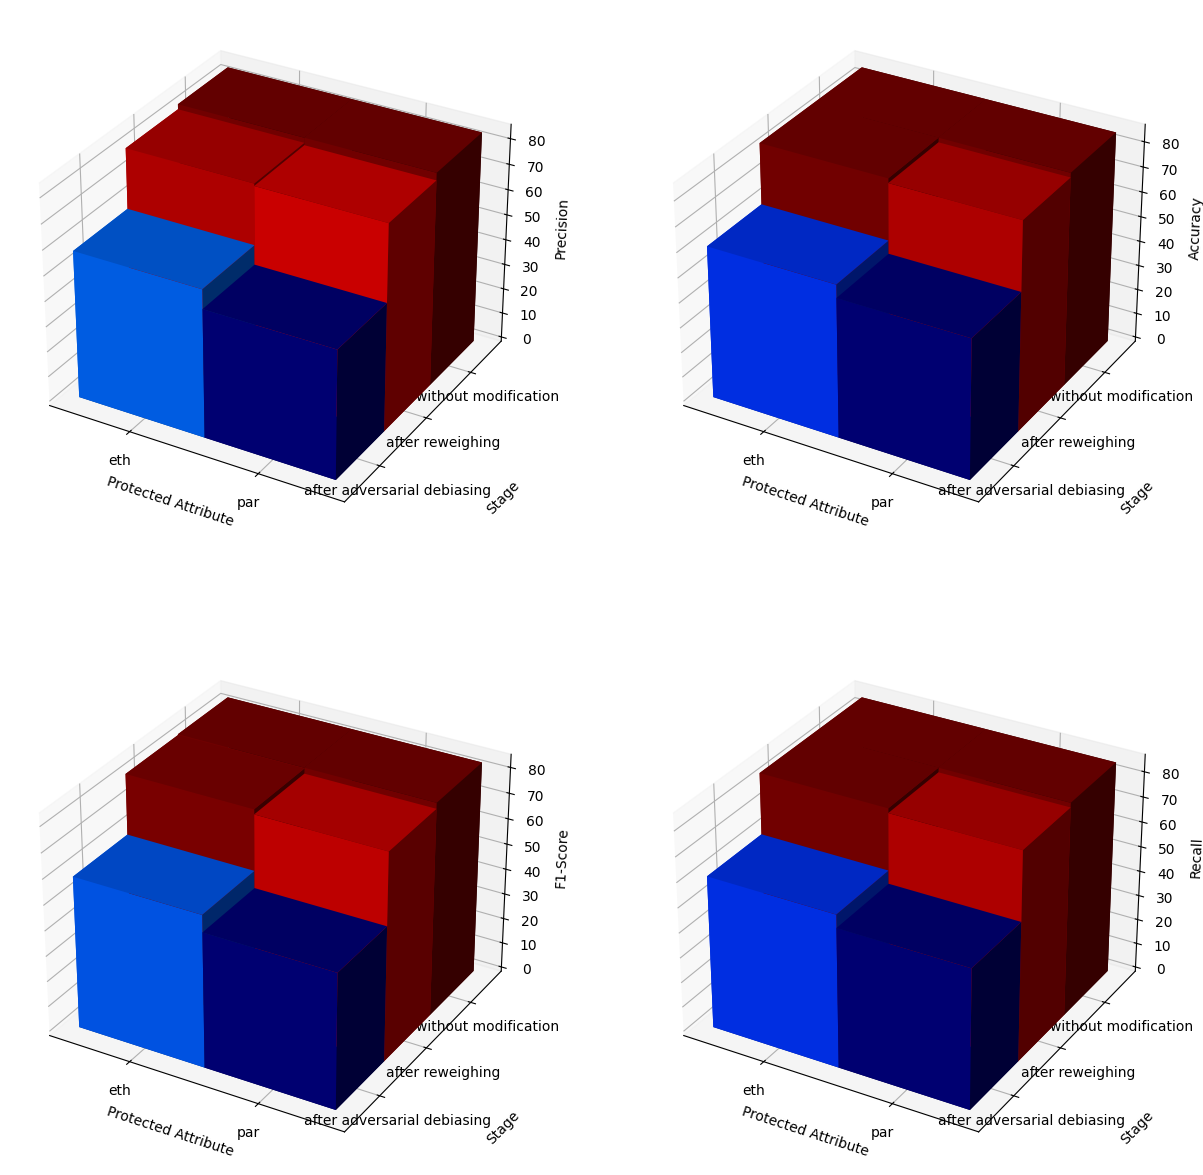

In [89]:
# And now for the plots
plot_cat_3d_barplot(df=ml_per_comp, x_axis_col='prot_attr', y_axis_col='stage', z_axis_cols=['precision', 'accuracy', 'f1-Score', 'recall'], 
                    x_label='Protected Attribute', y_label='Stage', z_labels=['Precision', 'Accuracy', 'F1-Score', 'Recall'])

### Results - Ml Performance after Bias Mitigation Techniques

As can be seen, bias reduction has some effect on the overall performance of the Random Forests used. Reweighing had a minimal effect on the performance of the Random Forests, whereas adversarial debiasing significantly reduced the performance on all four metrics.

As a last point, we compare the actual bias metrics for the Communities & Crime Dataset.

In [90]:
# Similar to the performance of the ml module, prepare the data for the 3d-barplot
par_bias_metr_comp = par_fin_bias_metrics_df.reset_index()
par_bias_metr_comp['prot_attr'] = 'par'


eth_bias_metr_comp = eth_fin_bias_metrics_df.reset_index()
eth_bias_metr_comp['prot_attr'] = 'eth'

bias_per_comp = pd.concat([eth_bias_metr_comp, par_bias_metr_comp], axis=0)
bias_per_comp = bias_per_comp.rename(columns={'index': 'stage'}).reset_index().drop(columns='index')
bias_per_comp = bias_per_comp.sort_values(by='stage', ascending=True)
bias_per_comp

,stage,without modification,after reweighing,after adversarial debiasing,after calculating equalized odds,prot_attr
2,consistency,0.92,0.92,1.00,1.00,eth
6,consistency,0.90,0.90,1.00,1.00,par
0,disp_impact_ratio,0.00,0.00,1.00,1.00,eth
4,disp_impact_ratio,0.00,0.00,1.00,1.00,par
3,smo_emp_diff_fair,1.10,0.72,0.00,0.00,eth
7,smo_emp_diff_fair,8.29,8.17,2.29,2.29,par
1,stat_par_diff,-1.00,-1.00,0.00,0.00,eth
5,stat_par_diff,-1.00,-1.00,0.00,0.00,par


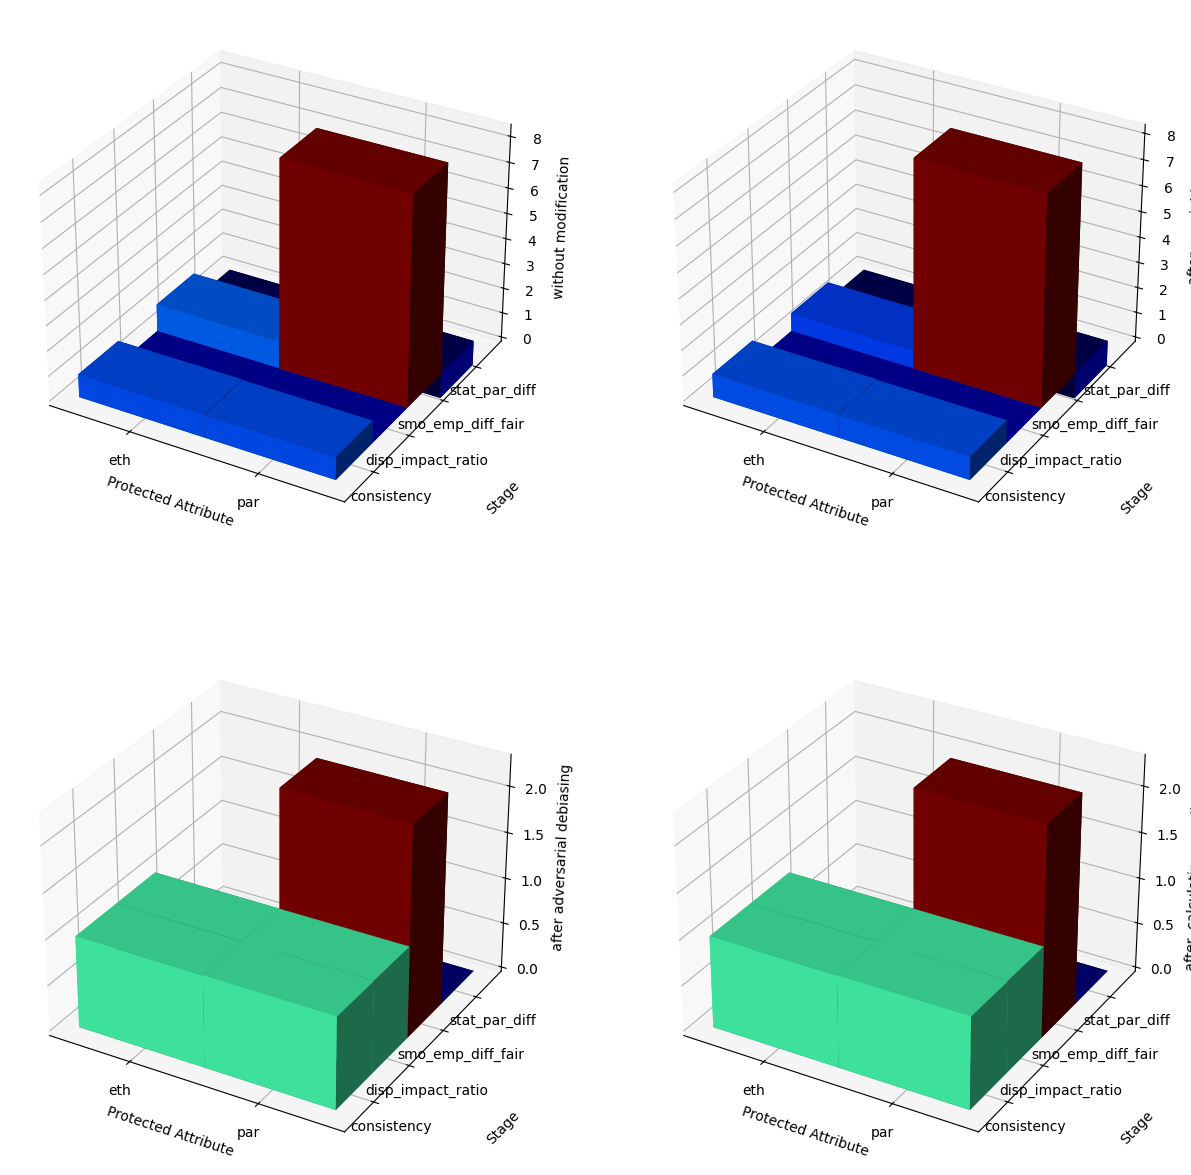

In [91]:
# Finally, plot the barplots
plot_cat_3d_barplot(df=bias_per_comp, 
                    x_axis_col='prot_attr', 
                    y_axis_col='stage', 
                    z_axis_cols=['without modification', 'after reweighing', 'after adversarial debiasing', 'after  calculating equalized odds'], 
                    x_label='Protected Attribute', 
                    y_label='Stage', 
                    z_labels=['without modification', 'after reweighing', 'after adversarial debiasing', 'after  calculating equalized odds'])

Unfortunately, sorting had no effect on changing the visibility of the columns. The results as well as the derived final remarks were interpreted from the data frame above.

#### Final Remarks

Both protected attributes produced a similar result. Reweighing had little effect on the bias metrics. Once adversarial debiasing was applied, bias was allegedly eliminated (except for the empirical difference fairness with single parent household as the protected attribute). Finally, in both cases the post-processing had no effect on the results. It is challenging to believe that the bias has been completely eliminated. Further validation with other datasets would be required to see whether adversarial debiasing in particular is as effective as these results suggest.

## References <a name="refs"></a>

[1] Redmond,Michael. (2011). Communities and Crime Unnormalized. UCI Machine Learning Repository. https://doi.org/10.24432/C5PC8X. <a name="viol_ds"></a>

[2] Bellamy, R. K., et al (2018).(2019). AI Fairness 360: An extensible toolkit for detecting and mitigating algorithmic bias. IBM Journal of Research and Development, 63(4/5), 4-1. <a name="aif360_ref"></a>

[3] IBM (2023). Disparate impact in Watson OpenScale fairness metrics | IBM Cloud Pak for Data as a Service. Available at: https://dataplatform.cloud.ibm.com/docs/content/wsj/model/wos-disparate-impact.html?context=data <a name="disp_imp"></a>

[4] IBM (n.d.). Statistical parity difference | IBM Cloud Pak for Data as a Service. Available at: https://dataplatform.cloud.ibm.com/docs/content/wsj/model/wos-stat-parity-diff.html?context=cpdaas <a name="stat_par"></a>

[5] IBM (2024). Smoothed empirical differential | IBM Cloud Pak for Data as a Service. Available at: https://dataplatform.cloud.ibm.com/docs/content/wsj/model/wos-smooth-empirical-diff.html?context=cpdaas <a name="emp_diff"></a>

[6] Scikit-learn (2018). sklearn.ensemble.RandomForestClassifier — scikit-learn 0.20.3 documentation. Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html. <a name="rf"></a>

[7] scikit-learn (2024). sklearn.linear_model.Perceptron. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html. <a name="per"></a>

[8] Scikit-learn (2009). sklearn.ensemble.GradientBoostingClassifier — scikit-learn 0.20.3 documentation. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html. <a name="cbg"></a>

[9] scikit-learn (2024). sklearn.ensemble.AdaBoostClassifier — scikit-learn 0.22.1 documentation. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html. <a name="abc"></a>

[10] Kamiran, F., & Calders, T. (2012). Data preprocessing techniques for classification without discrimination. Knowledge and information systems, 33(1), 1-33. <a name="reweighing"></a>

[11] Zhang, B. H., Lemoine, B., & Mitchell, M. (2018, December). Mitigating unwanted biases with adversarial learning. In Proceedings of the 2018 AAAI/ACM Conference on AI, Ethics, and Society (pp. 335-340). <a name="adv_deb"></a>

[12] Pleiss, G., Raghavan, M., Wu, F., Kleinberg, J., & Weinberger, K. Q. (2017). On fairness and calibration. Advances in neural information processing systems, 30. <a name="cal_eq_odds"></a>